In [1]:
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib import gridspec

from helper import *
from peg_sim import PegSimulator
from manage import startSession, finishSession

from sae import StateAutoEncoder
from aae import ActionAutoEncoder

from sd import StateDiscriminator
from ad import ActionDiscriminator

Using TensorFlow backend.


In [2]:
# Global Settings
startSession(memory=0.5)

STATE_ENCODING = (33, 2)
ACTION_ENCODING = (8, 2)

In [3]:
# Load all networks

## SAE
sae_model_net = [[4, 7], 275]
sae_model = StateAutoEncoder(network_shape=sae_model_net, latent_shape=STATE_ENCODING, domain=True, use_latent=False)
print('SAE', sae_model.load())

## AAE
aae_model_net = [100, 140]
aae_model = ActionAutoEncoder(data_shape=(STATE_ENCODING[0],), latent_shape=ACTION_ENCODING, network_shape=aae_model_net)
print('AAE', aae_model.load())

## SD
sd_model_net = [80]
sd_model = StateDiscriminator(data_shape=(STATE_ENCODING[0],), network_shape=sd_model_net)
print('SD', sd_model.load())
sd_C = 0.9 # Last calculated C

## AD
ad_model_net = [140]
ad_model = ActionDiscriminator(data_shape=(STATE_ENCODING[0],), network_shape=ad_model_net)
print('AD', ad_model.load())
ad_C = 0.9 # Last calculated C

Domain Knowledge Network
Loaded Model
SAE True
Building Network
Loaded Model
AAE True
Building Network
Loaded Model
SD True
Building Network
Loaded Model
AD True


-------------- STEP 0 ---------------------
Unique Actions: 161
Prune SD: 159
Prune AD: 5
Enc/Dec SAE: 5
Enc/Dec AAE: 4
-------------- STEP 1 ---------------------
Unique Actions: 164
Prune SD: 163
Prune AD: 5
Enc/Dec SAE: 5
Enc/Dec AAE: 3
-------------- STEP 2 ---------------------
Unique Actions: 153
Prune SD: 153
Prune AD: 5
Enc/Dec SAE: 5
Enc/Dec AAE: 5
-------------- STEP 3 ---------------------
Unique Actions: 149
Prune SD: 149
Prune AD: 8
Enc/Dec SAE: 8
Enc/Dec AAE: 8
-------------- STEP 4 ---------------------
Unique Actions: 148
Prune SD: 148
Prune AD: 6
Enc/Dec SAE: 6
Enc/Dec AAE: 6


c:\users\antoine\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


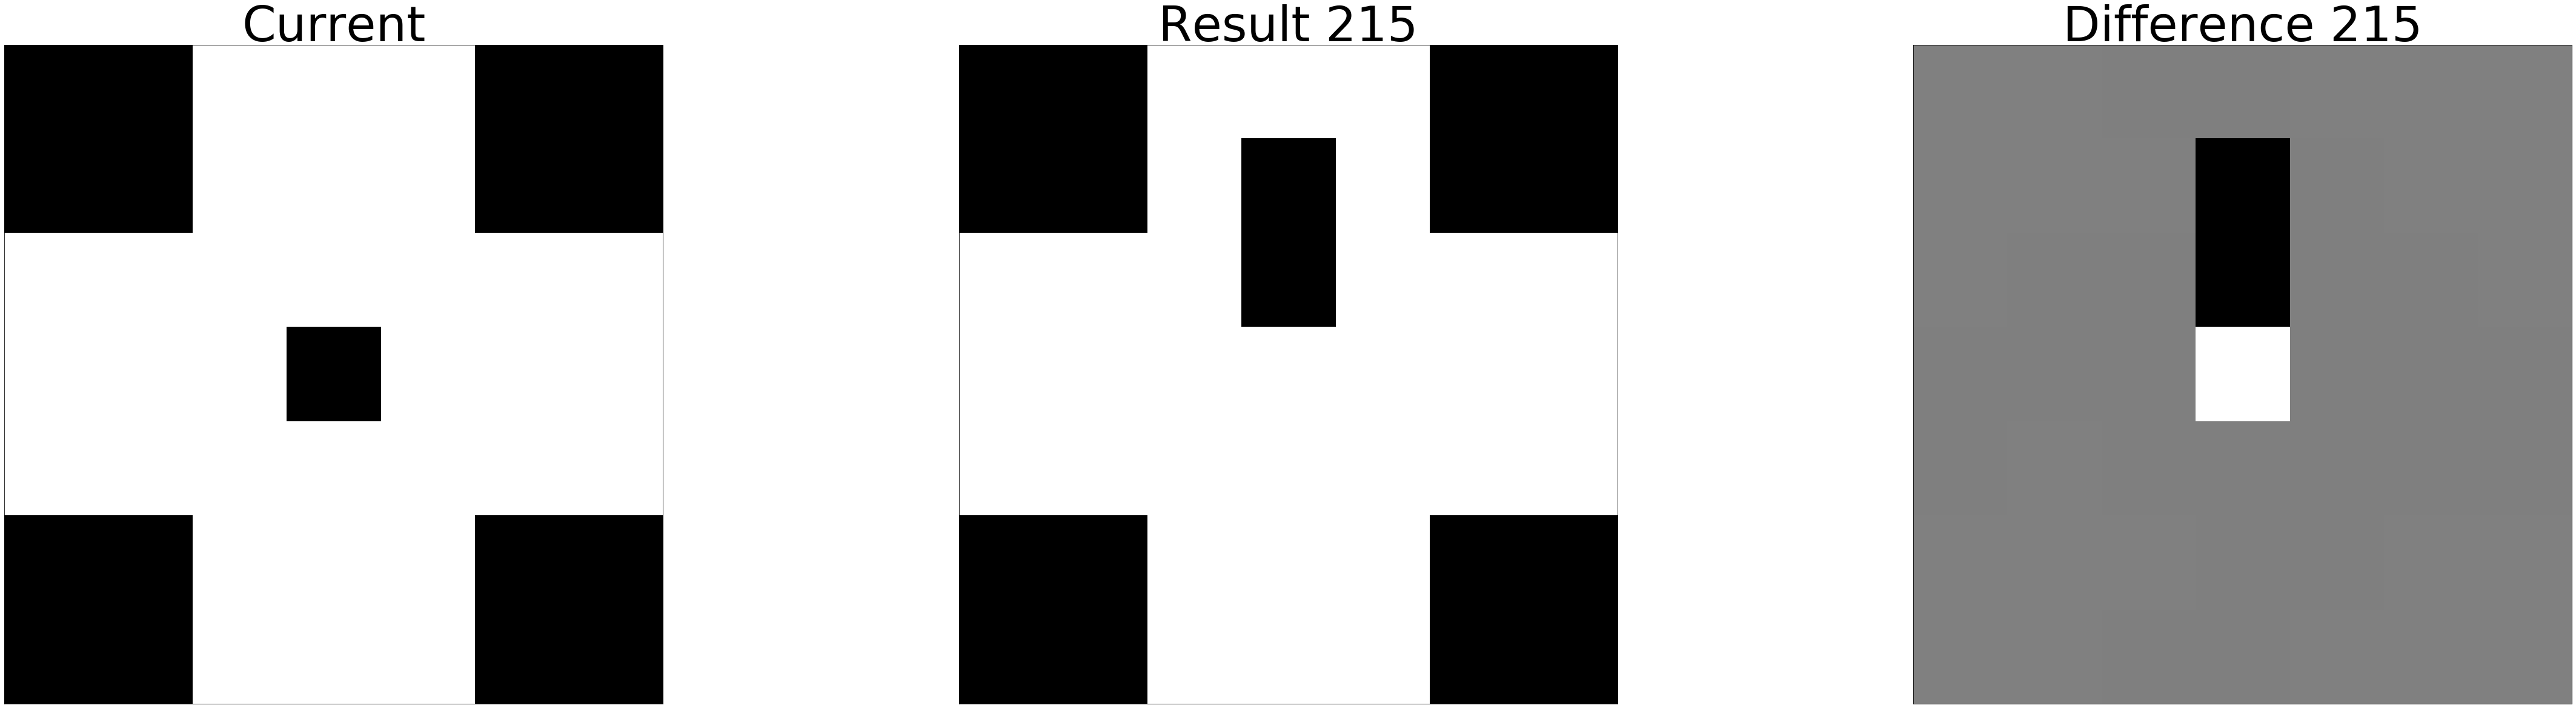

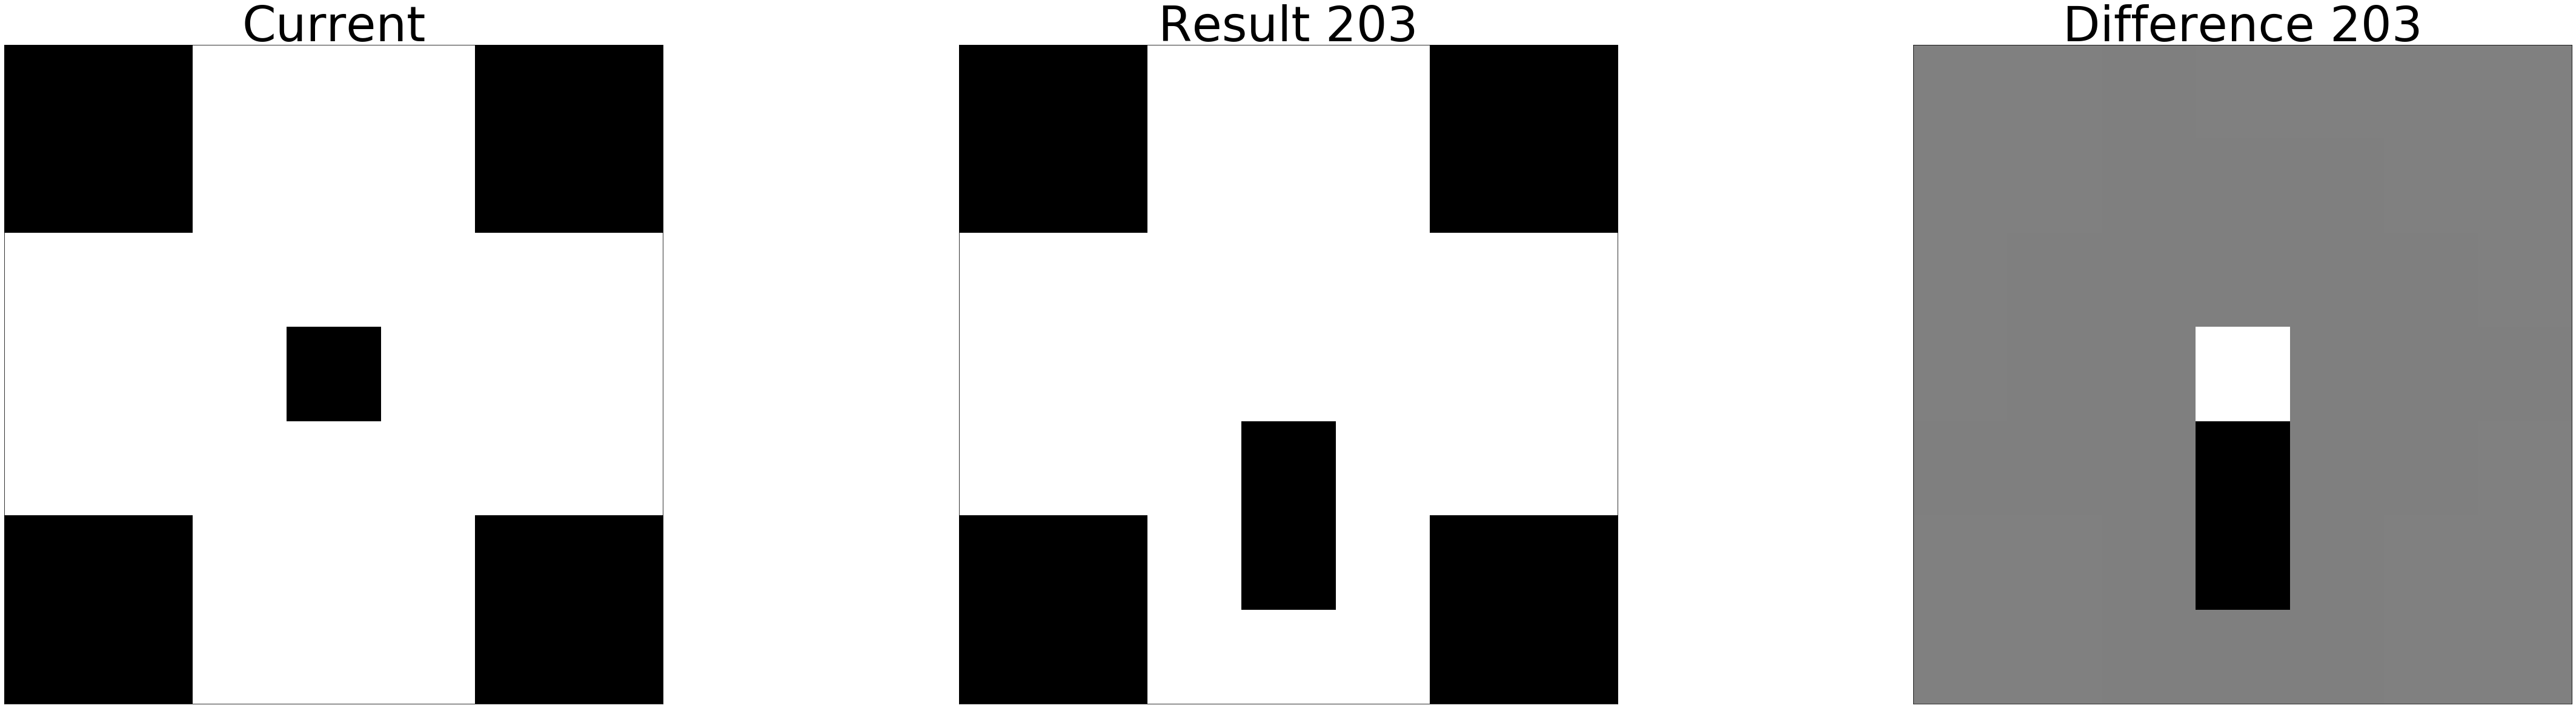

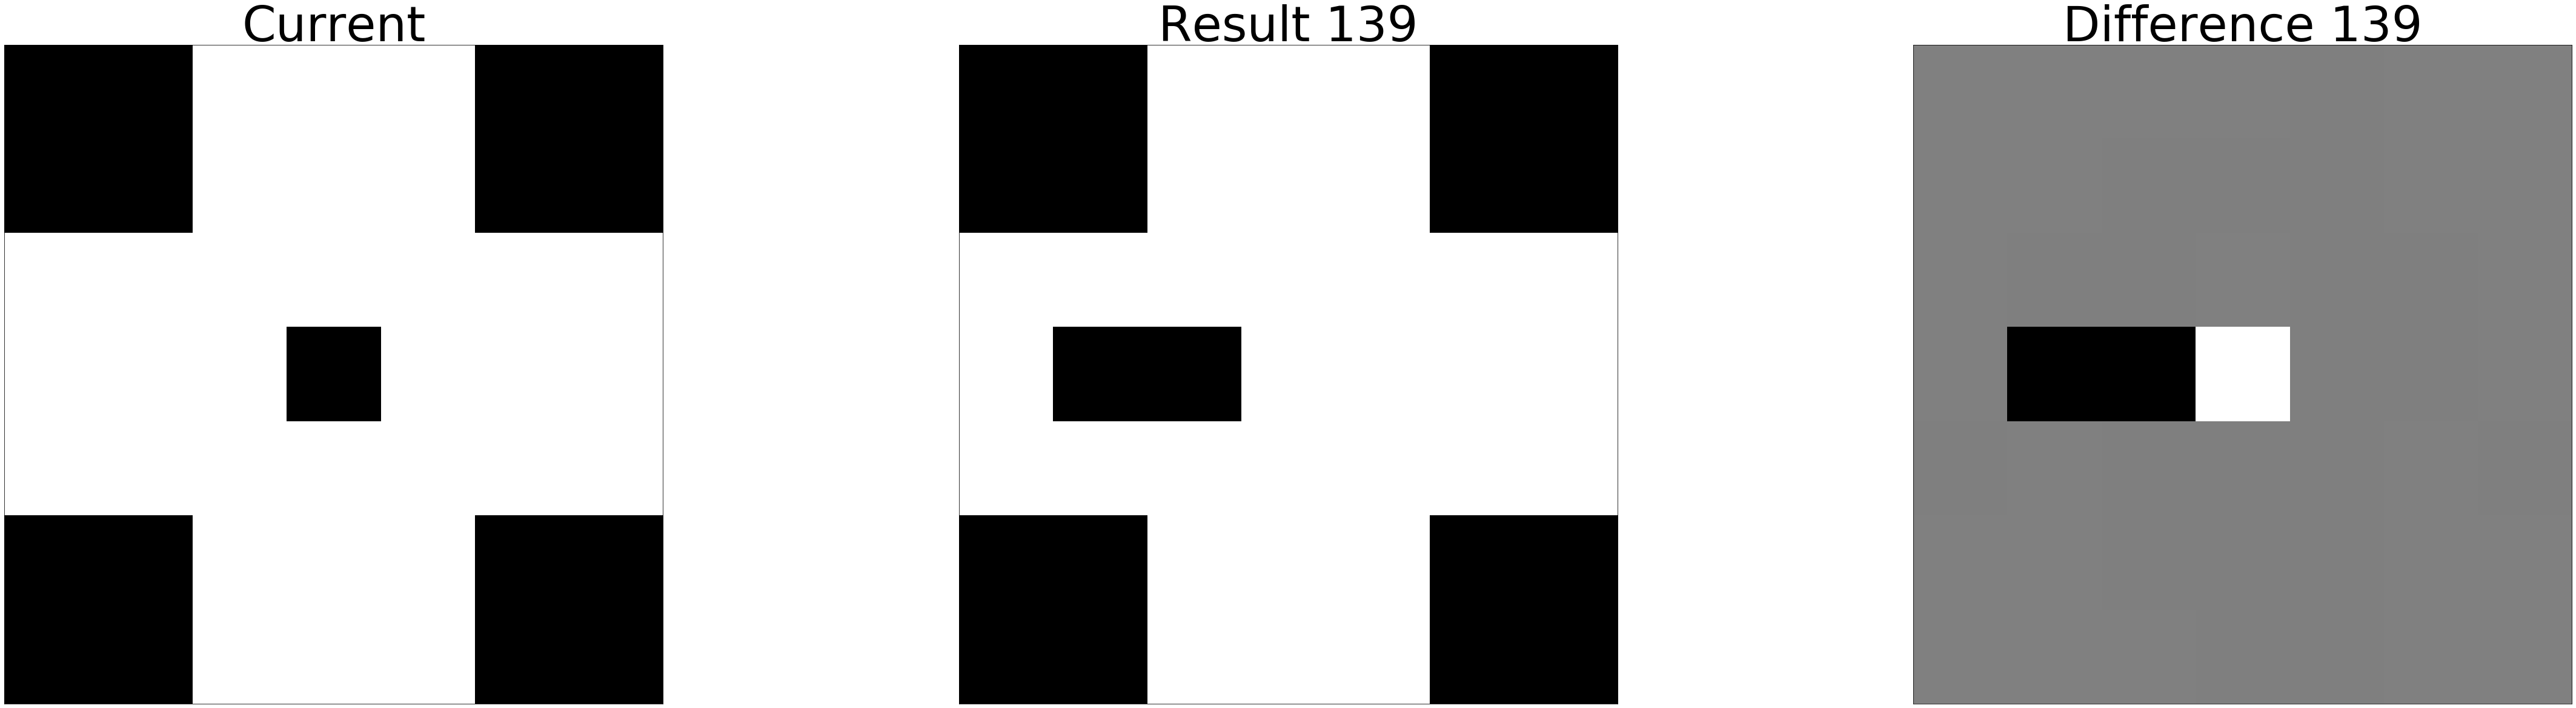

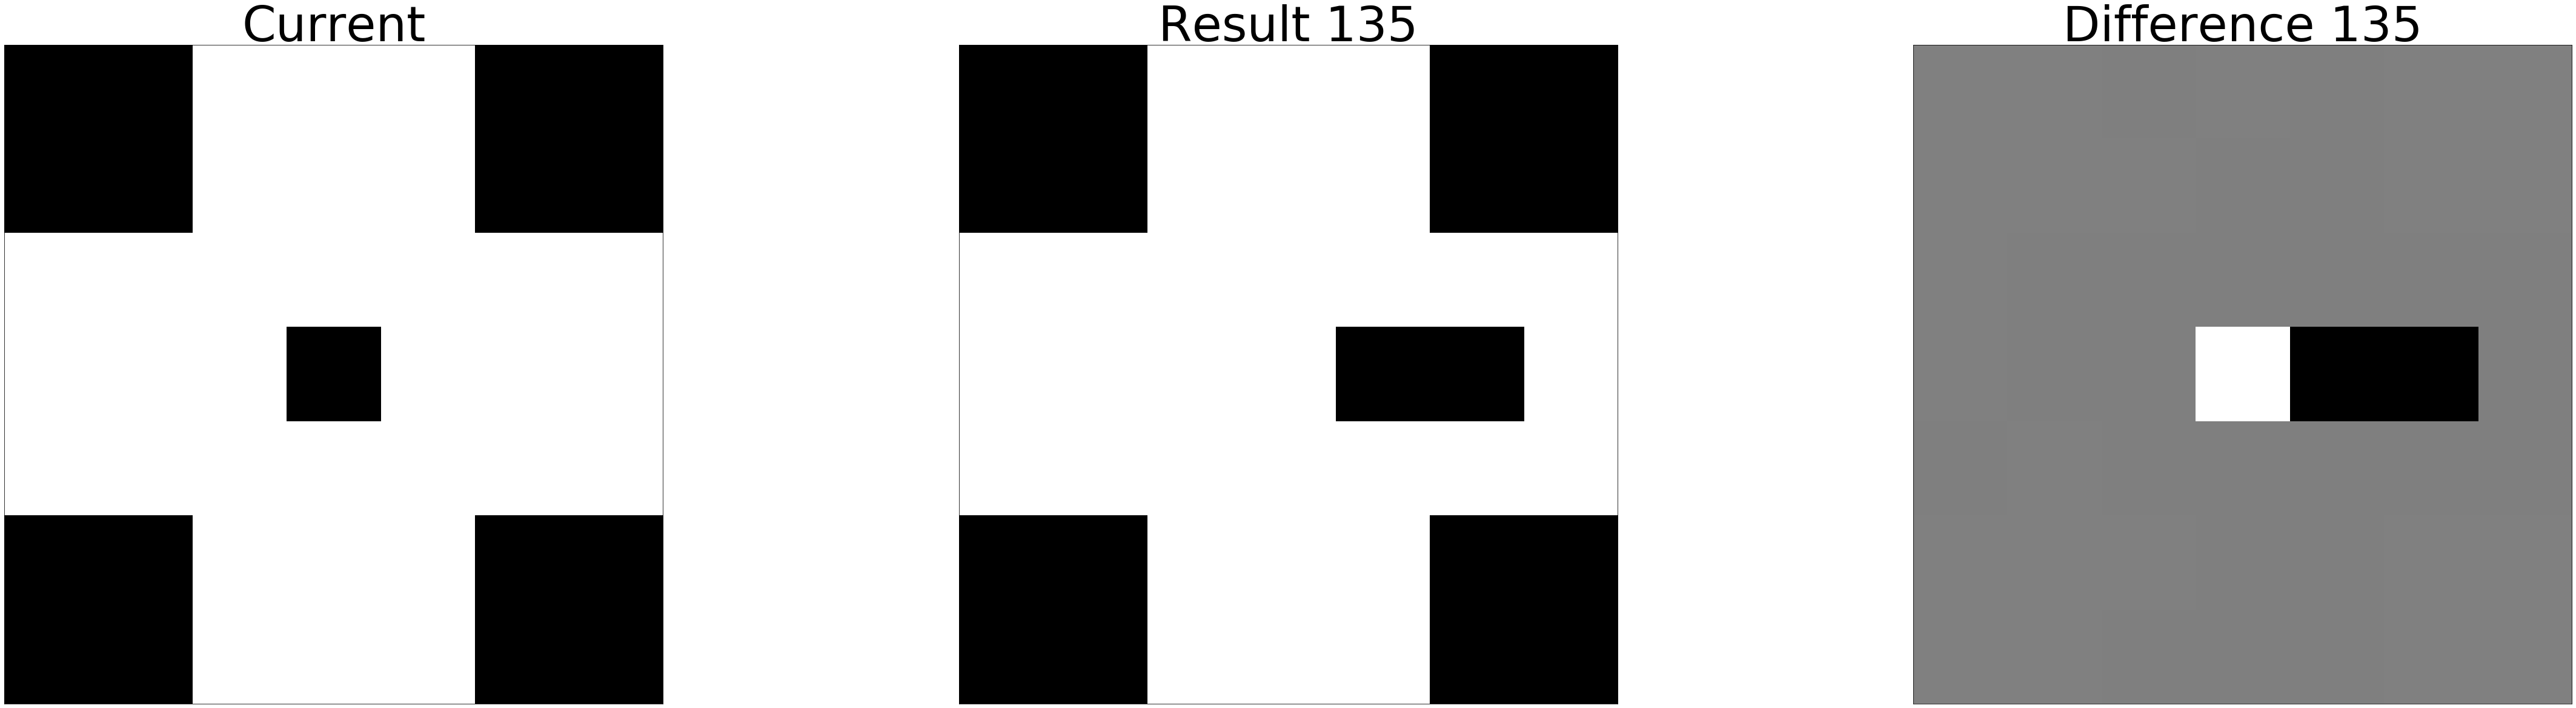

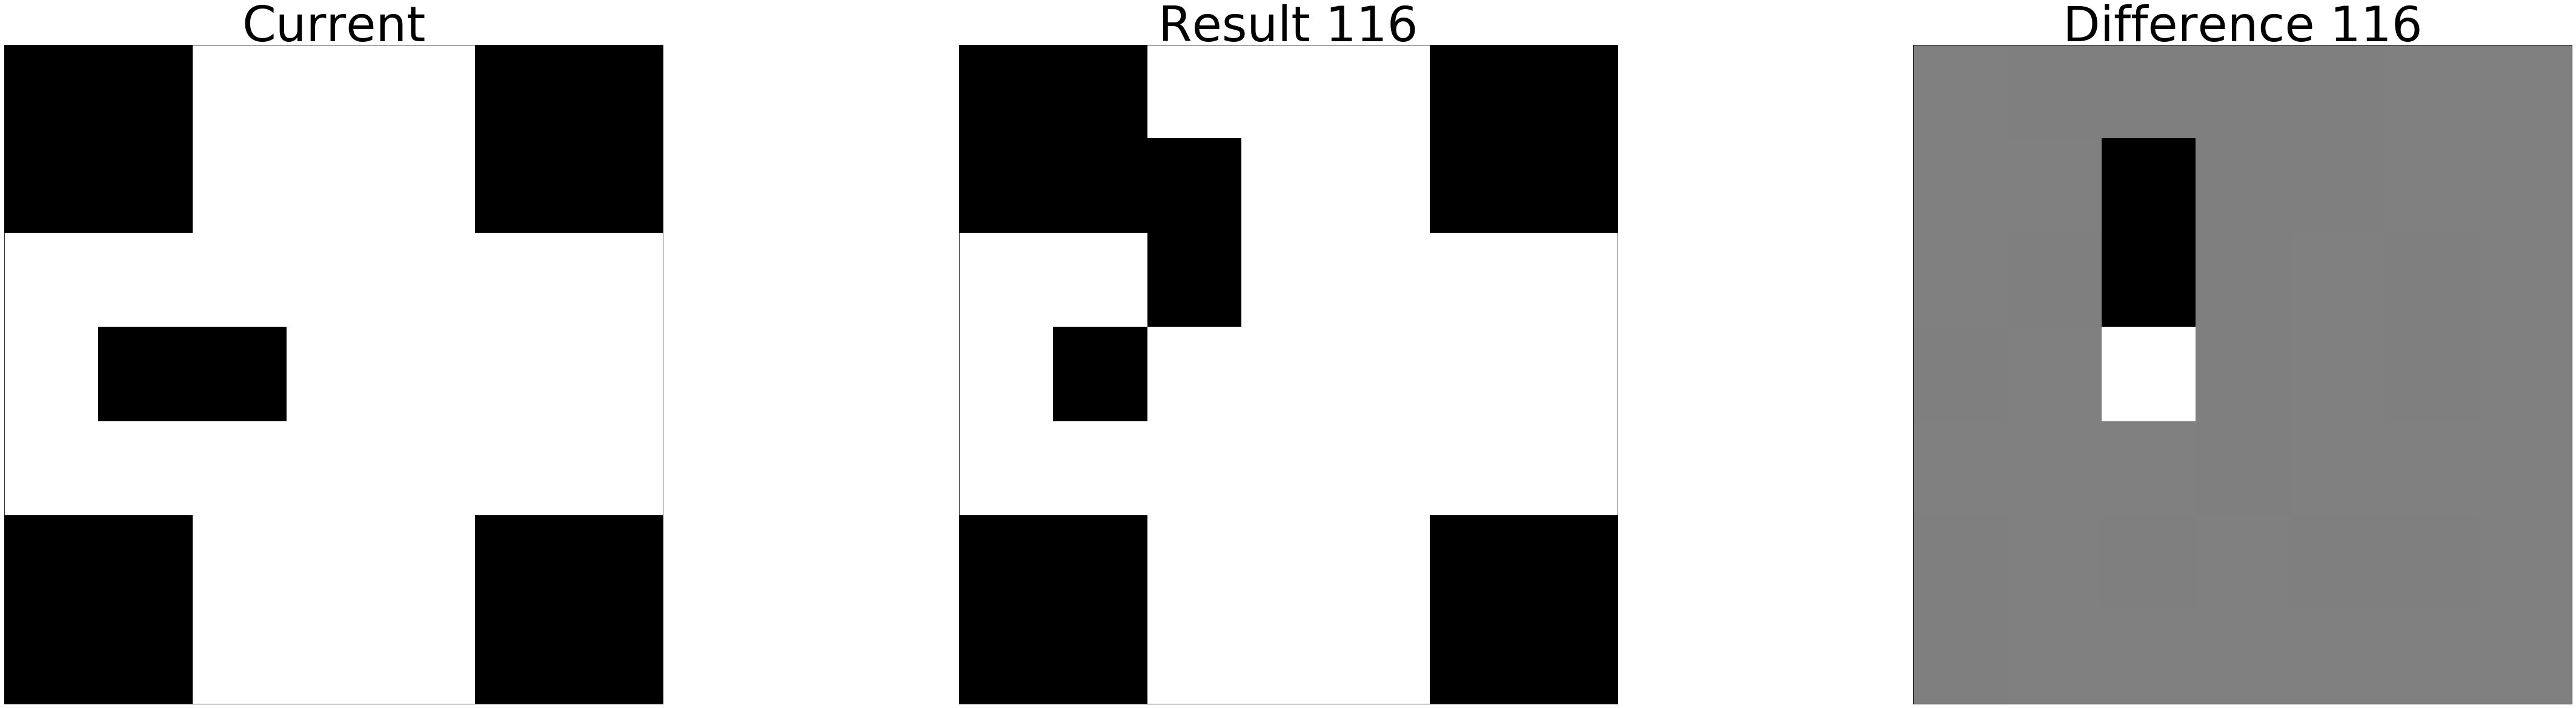

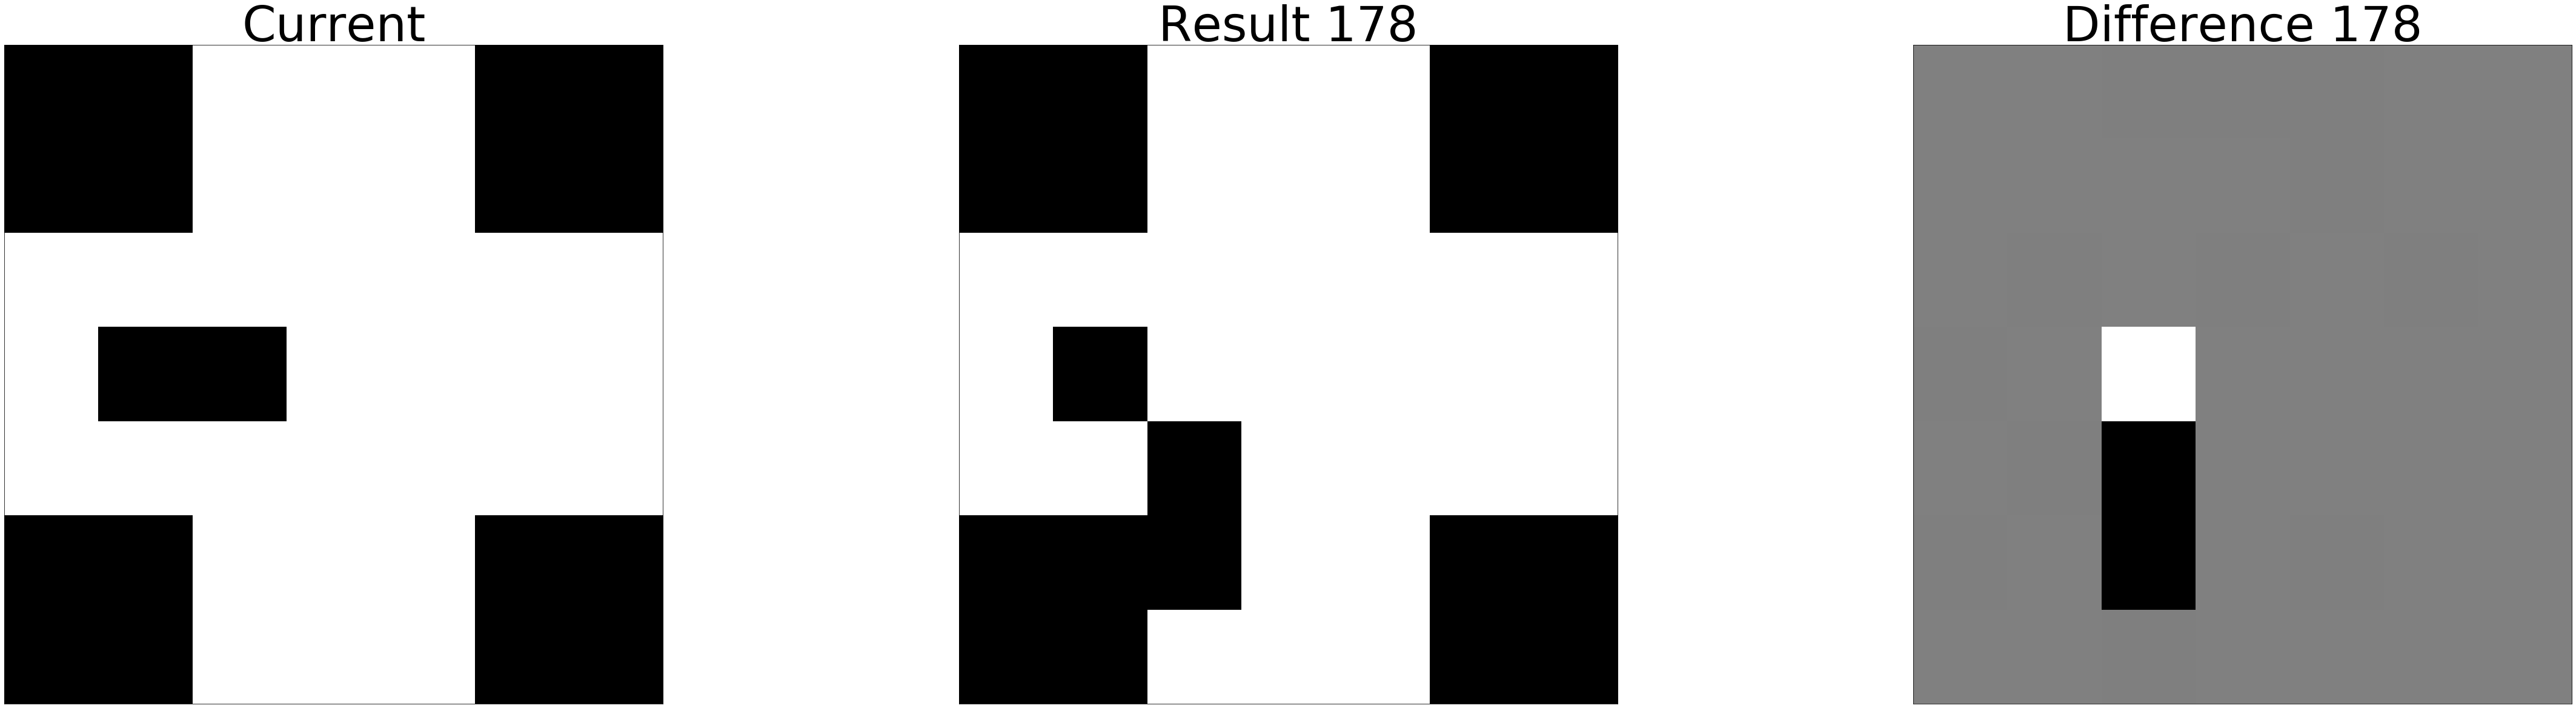

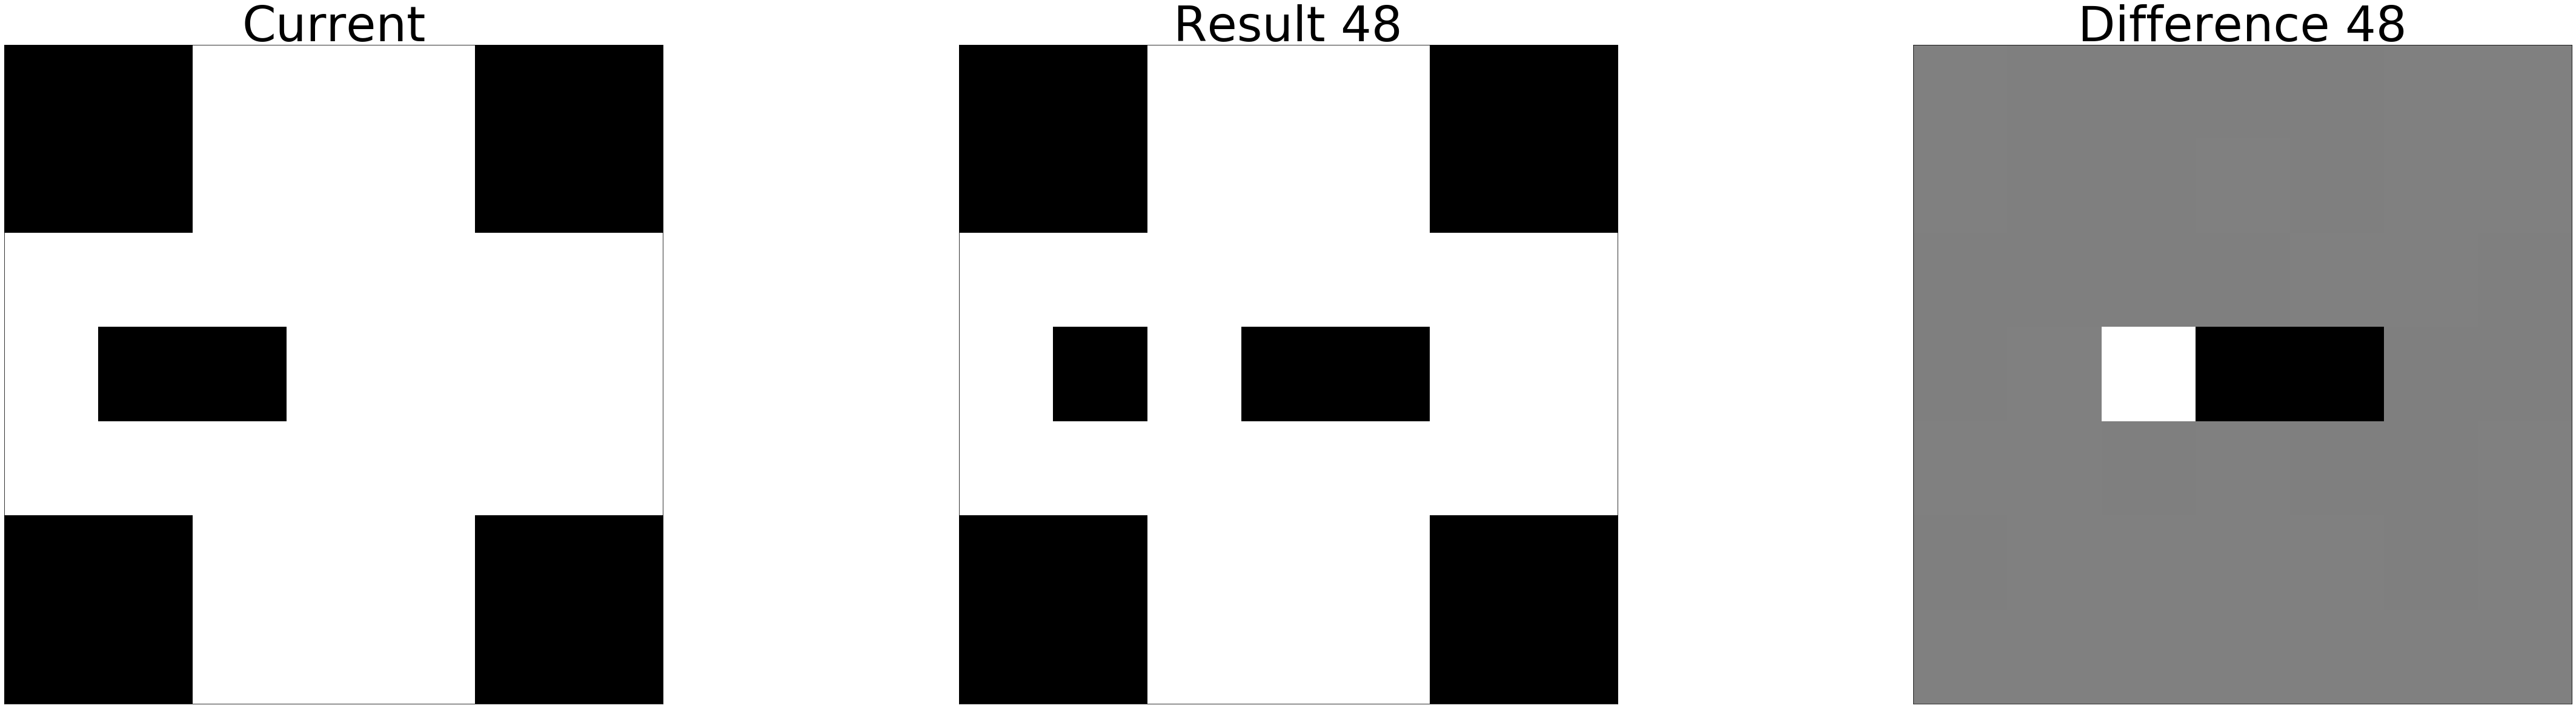

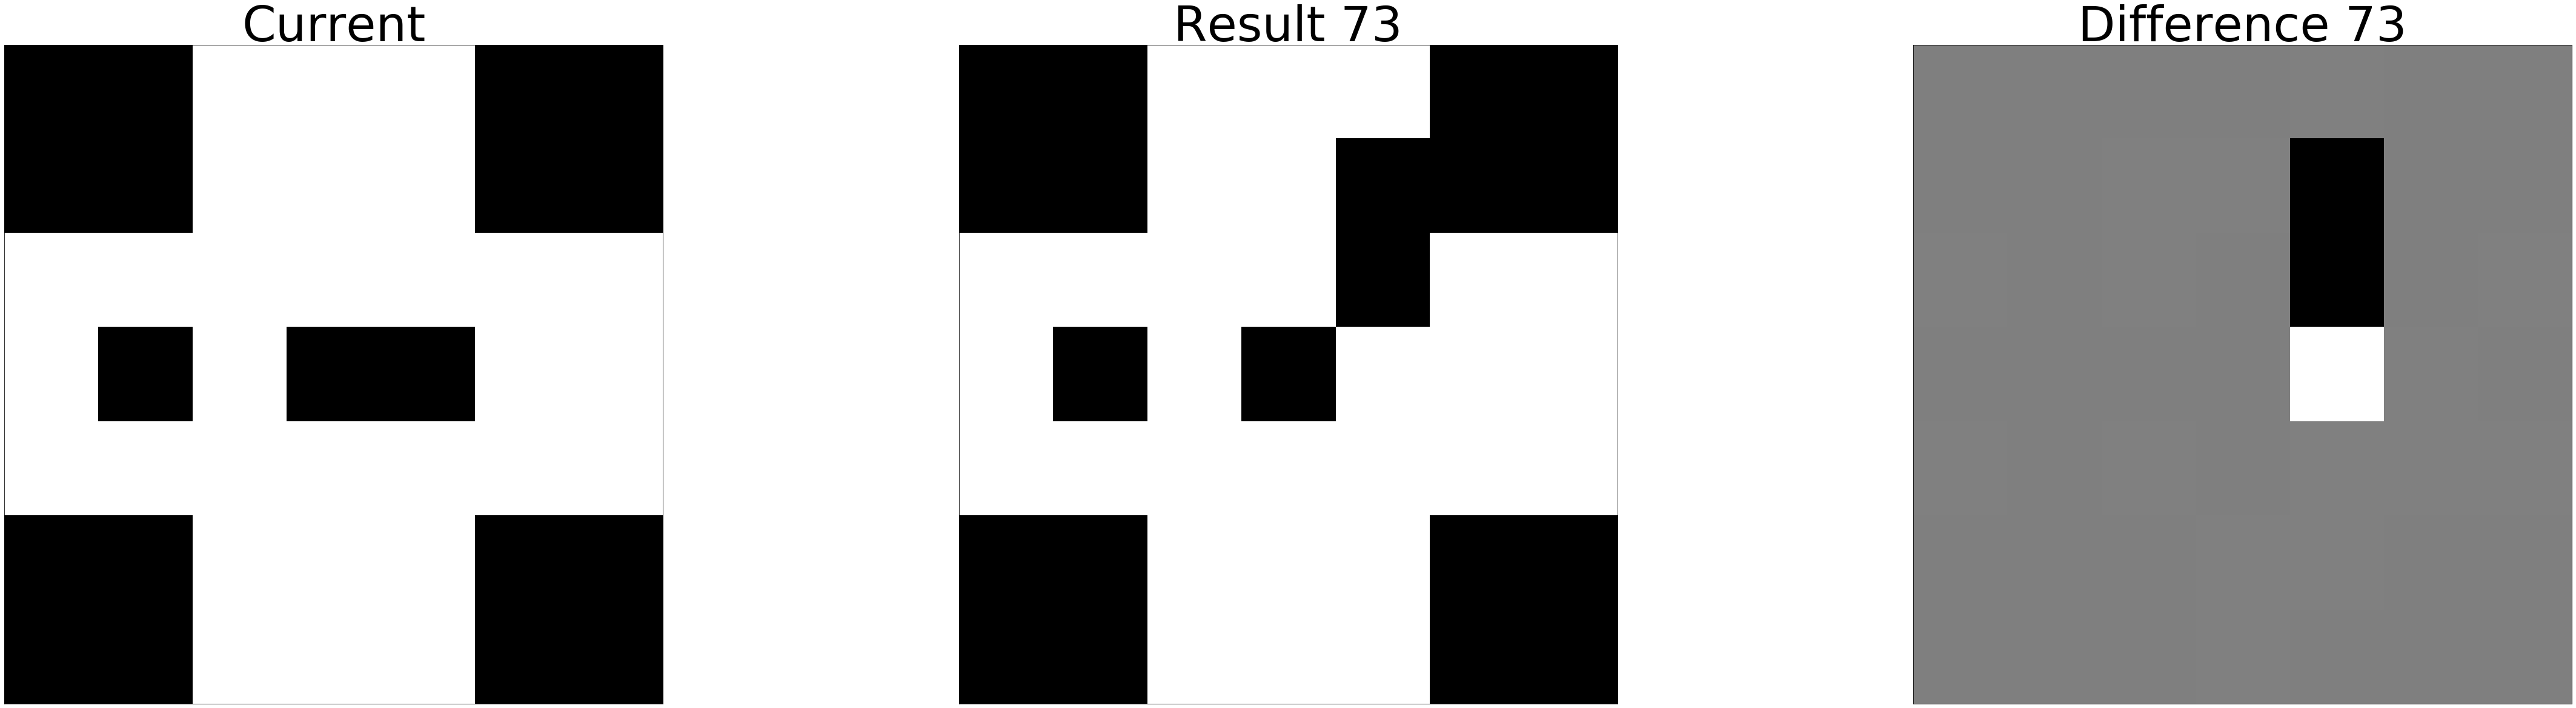

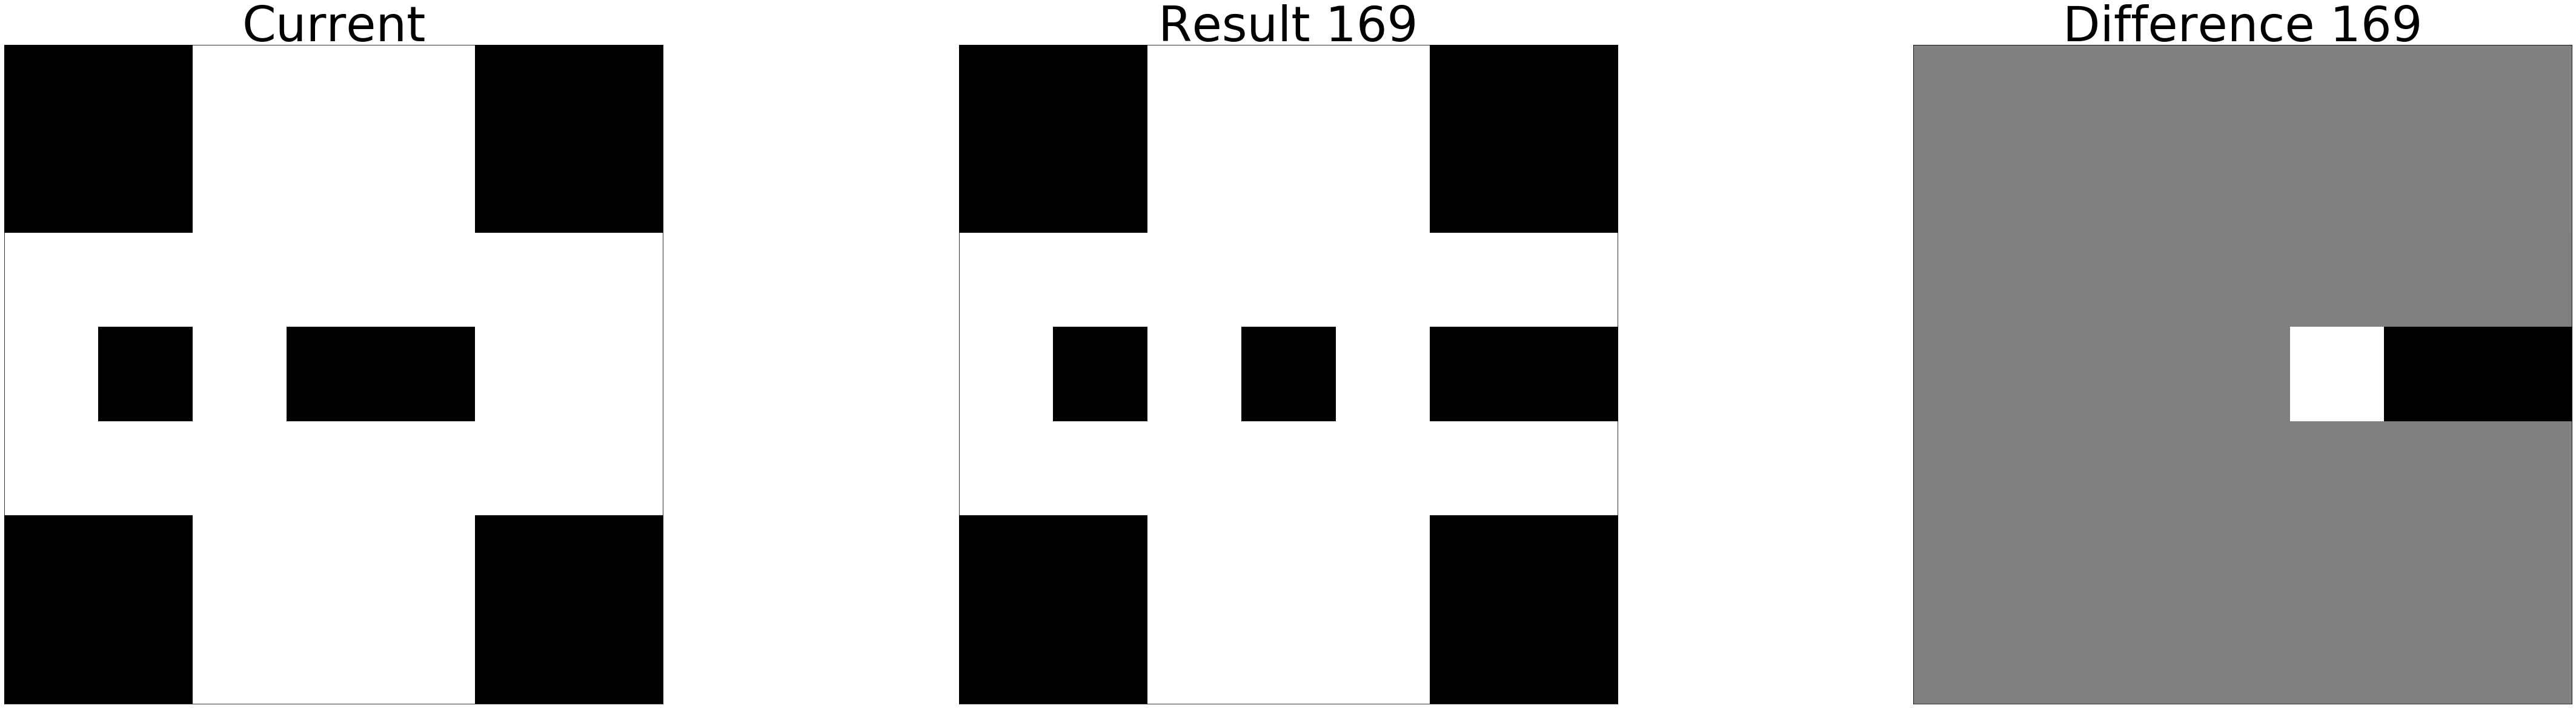

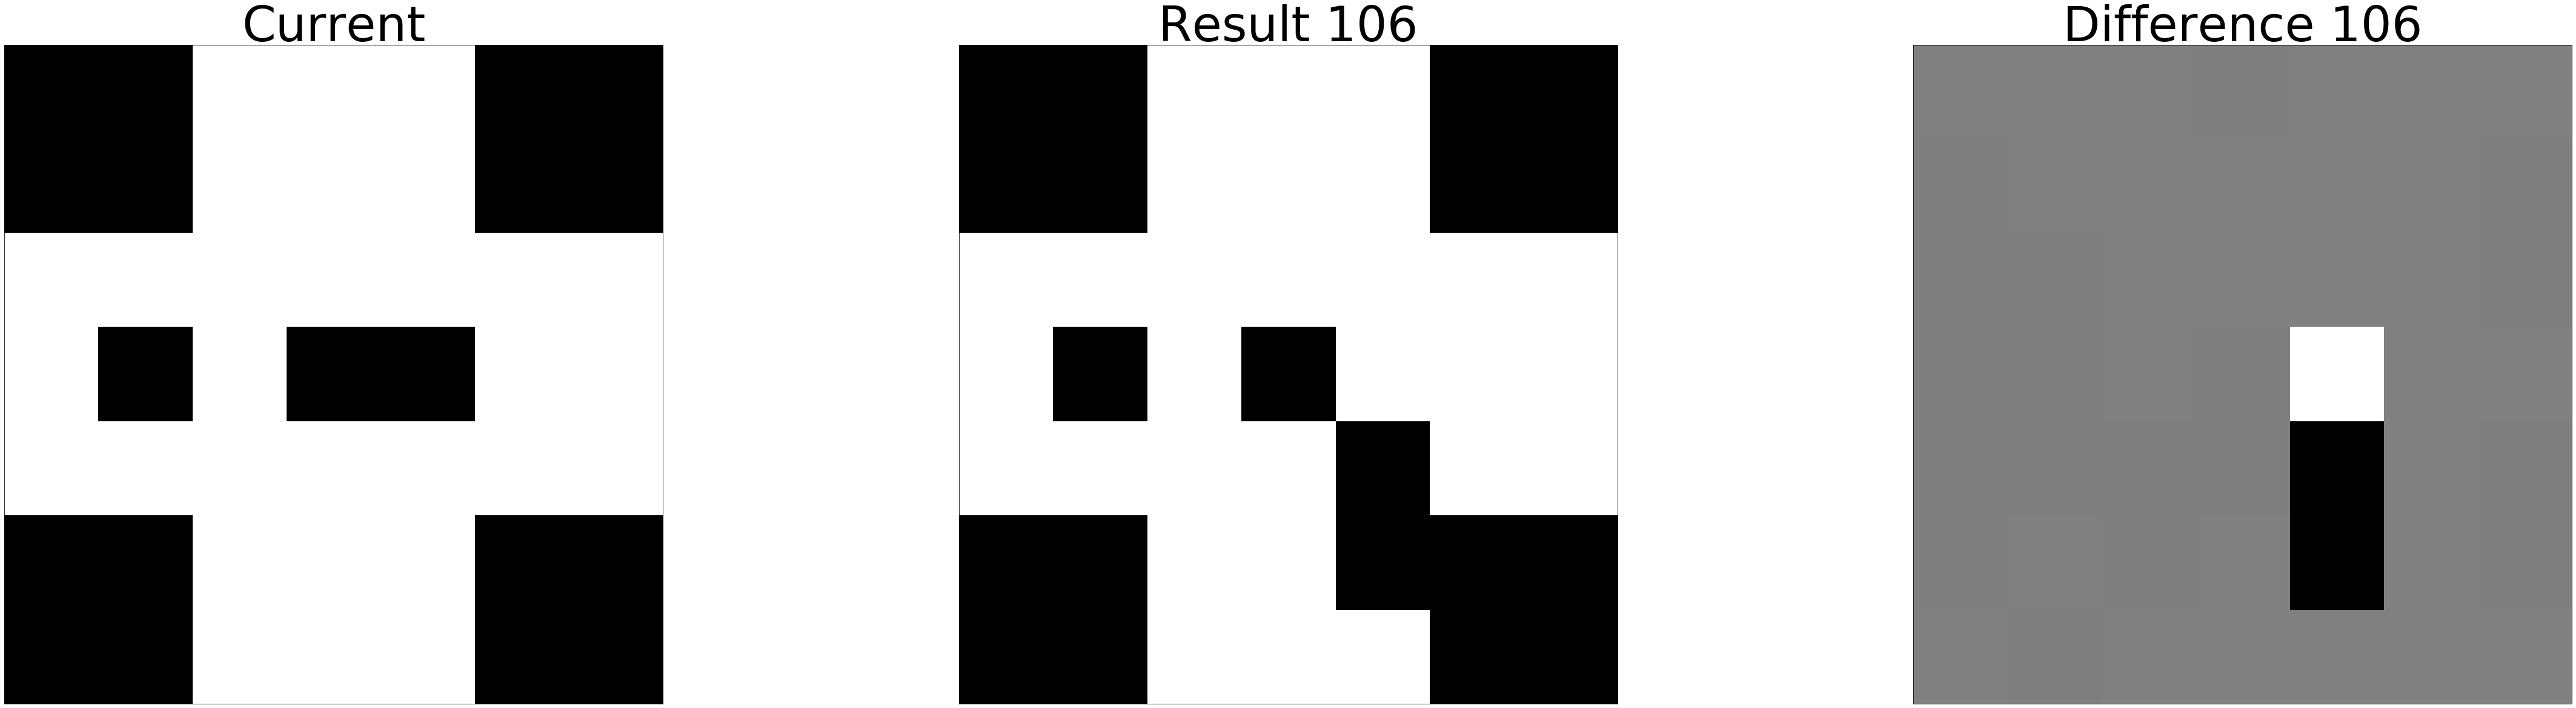

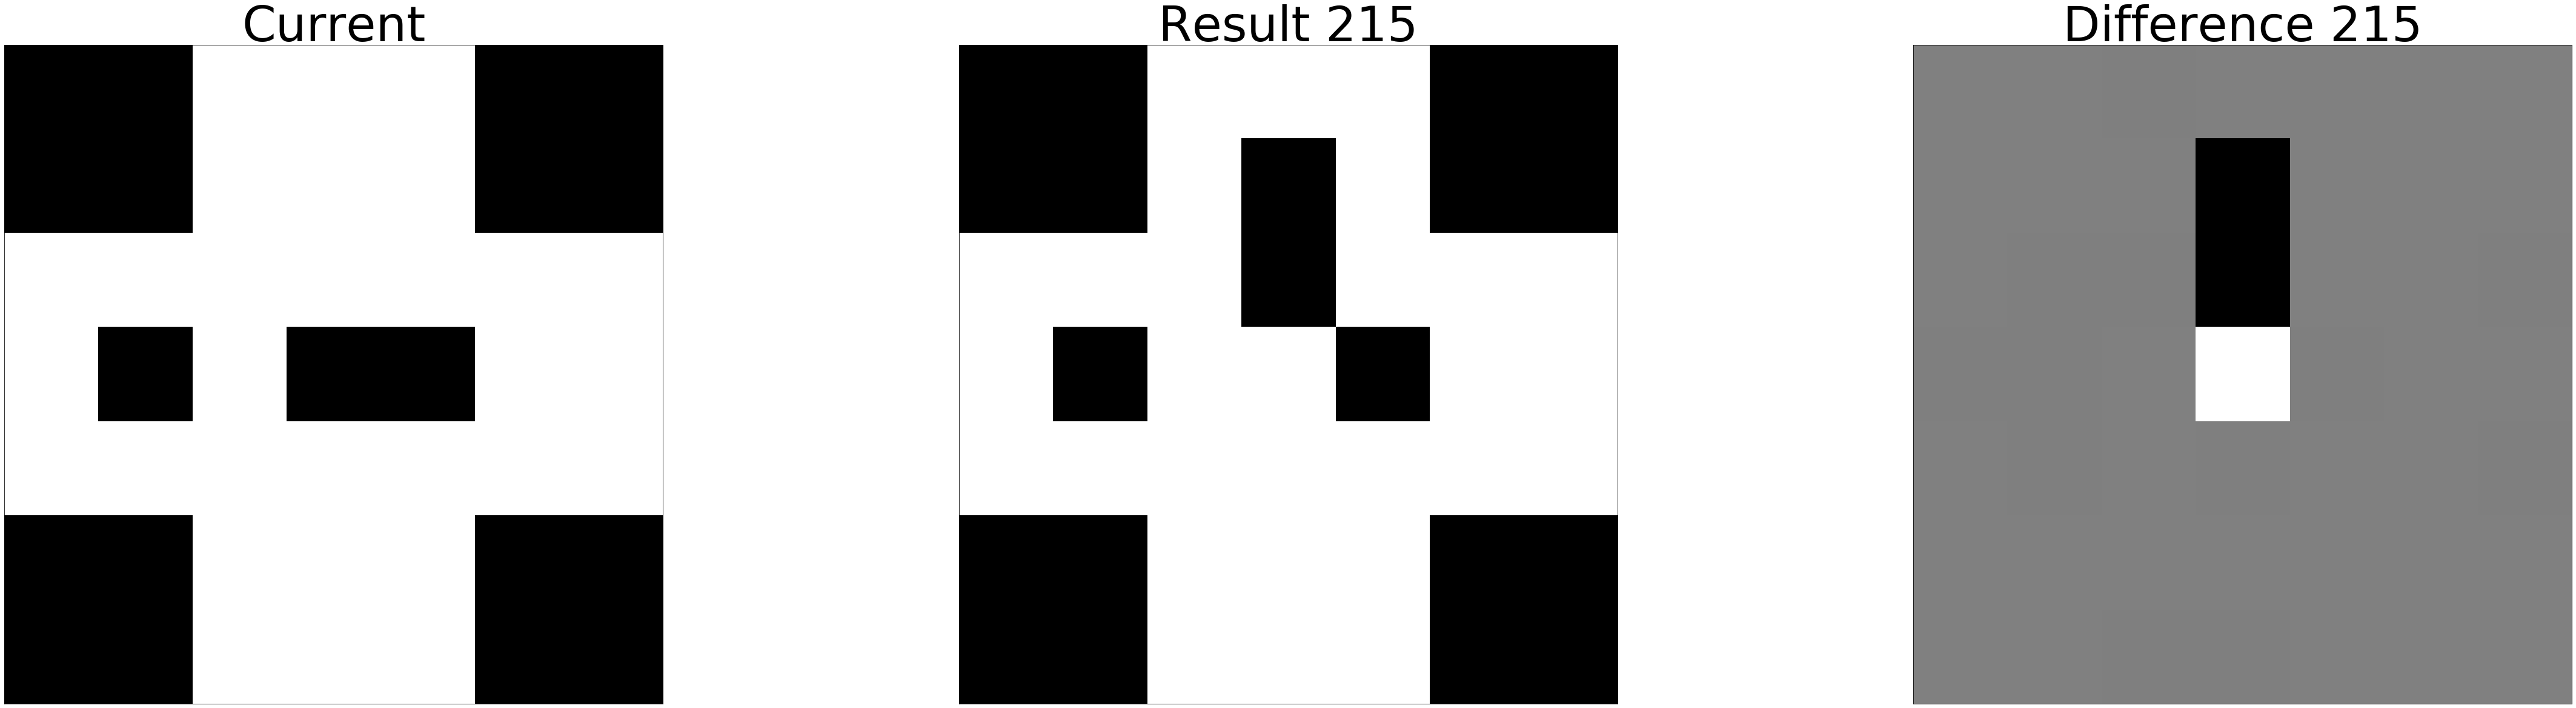

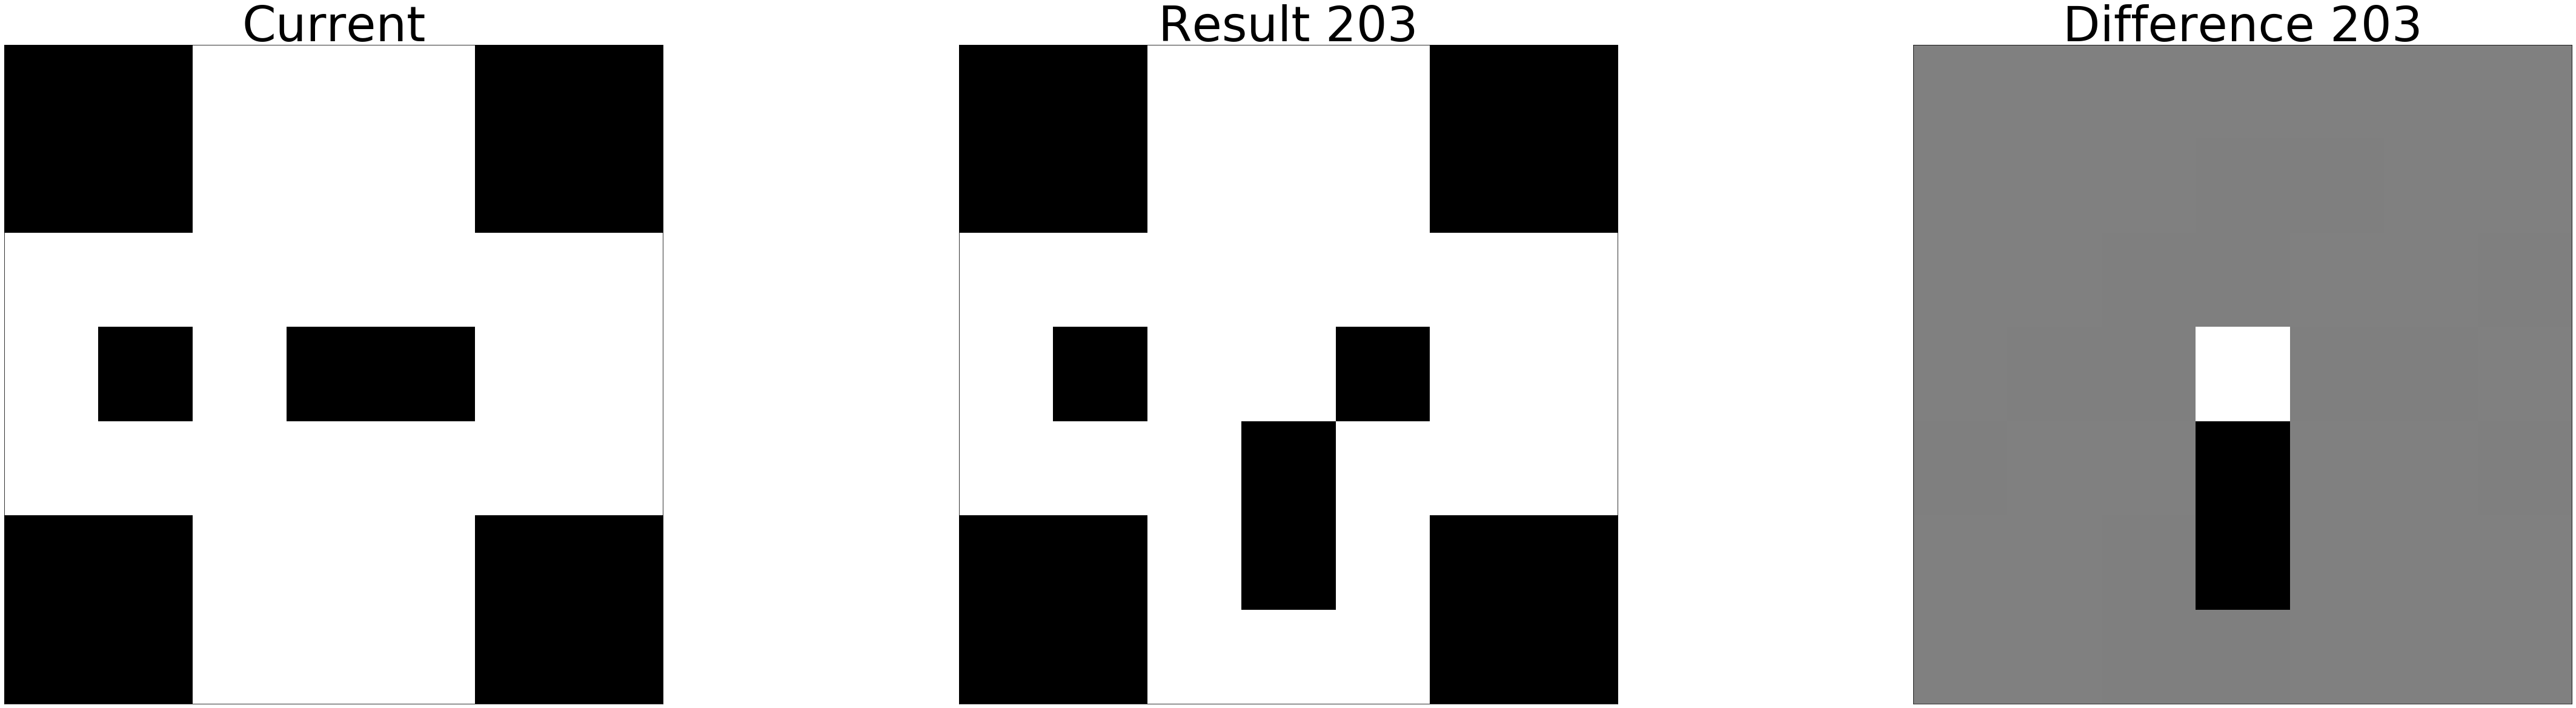

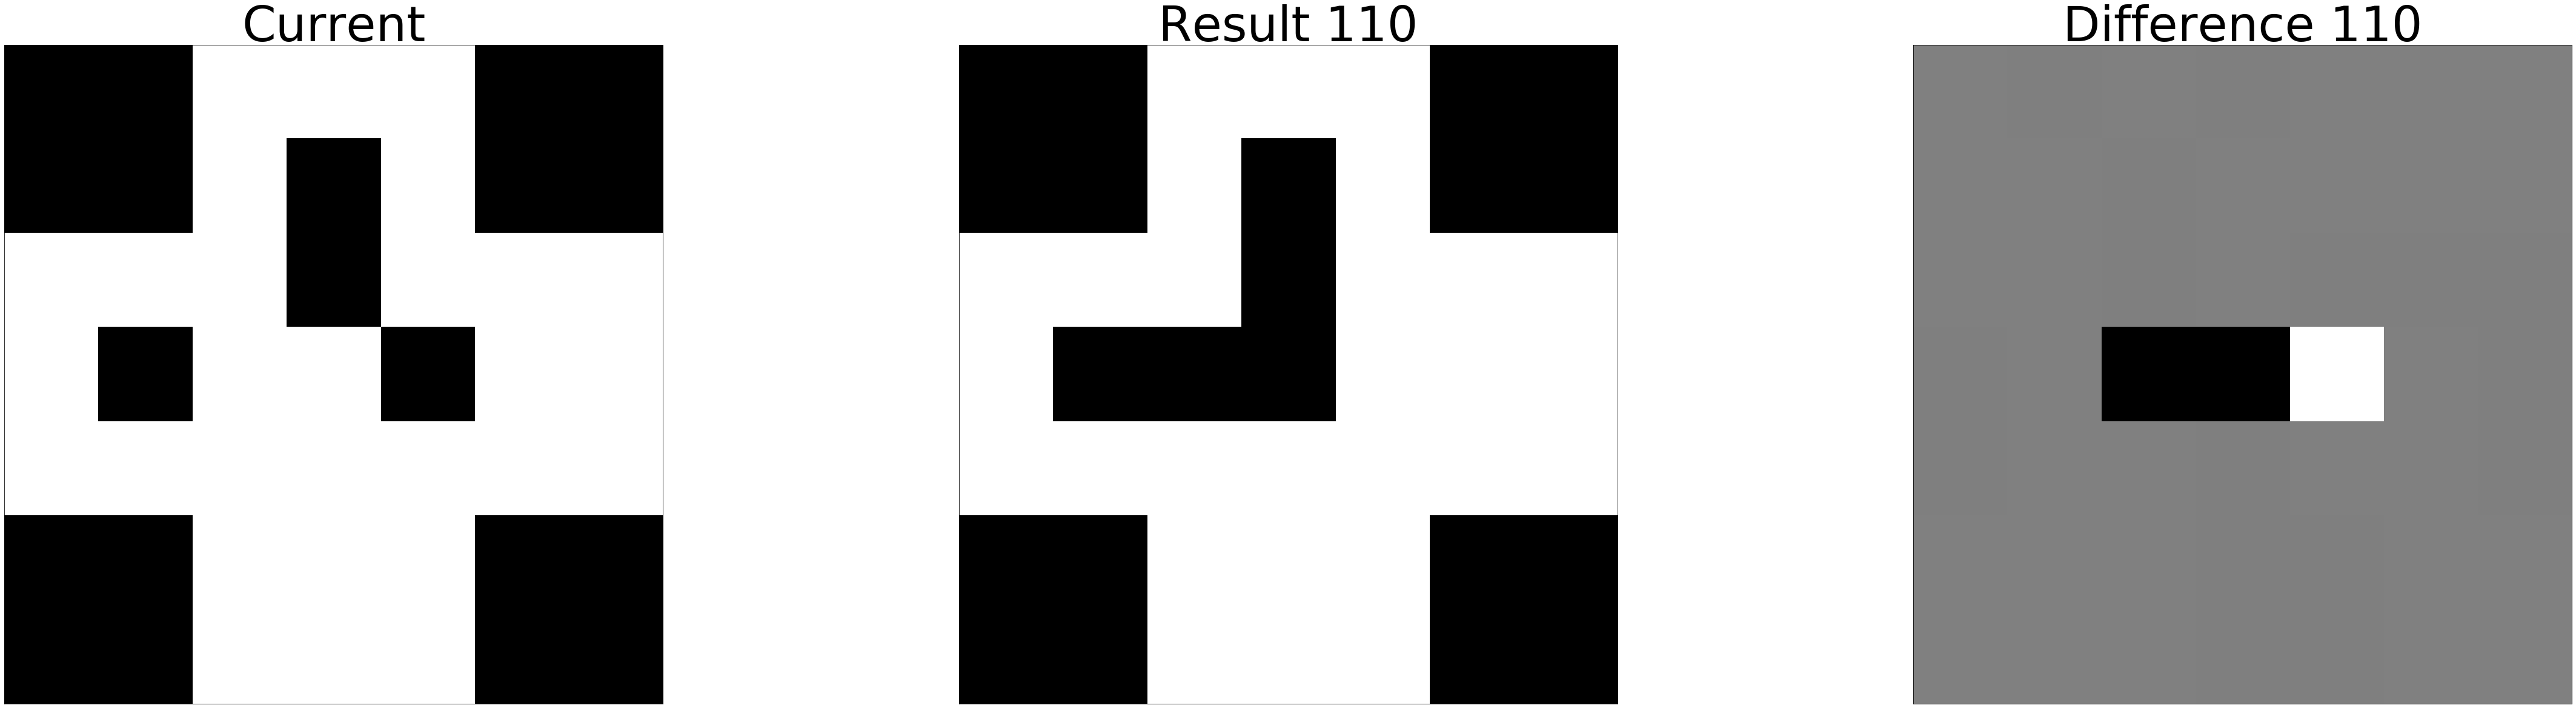

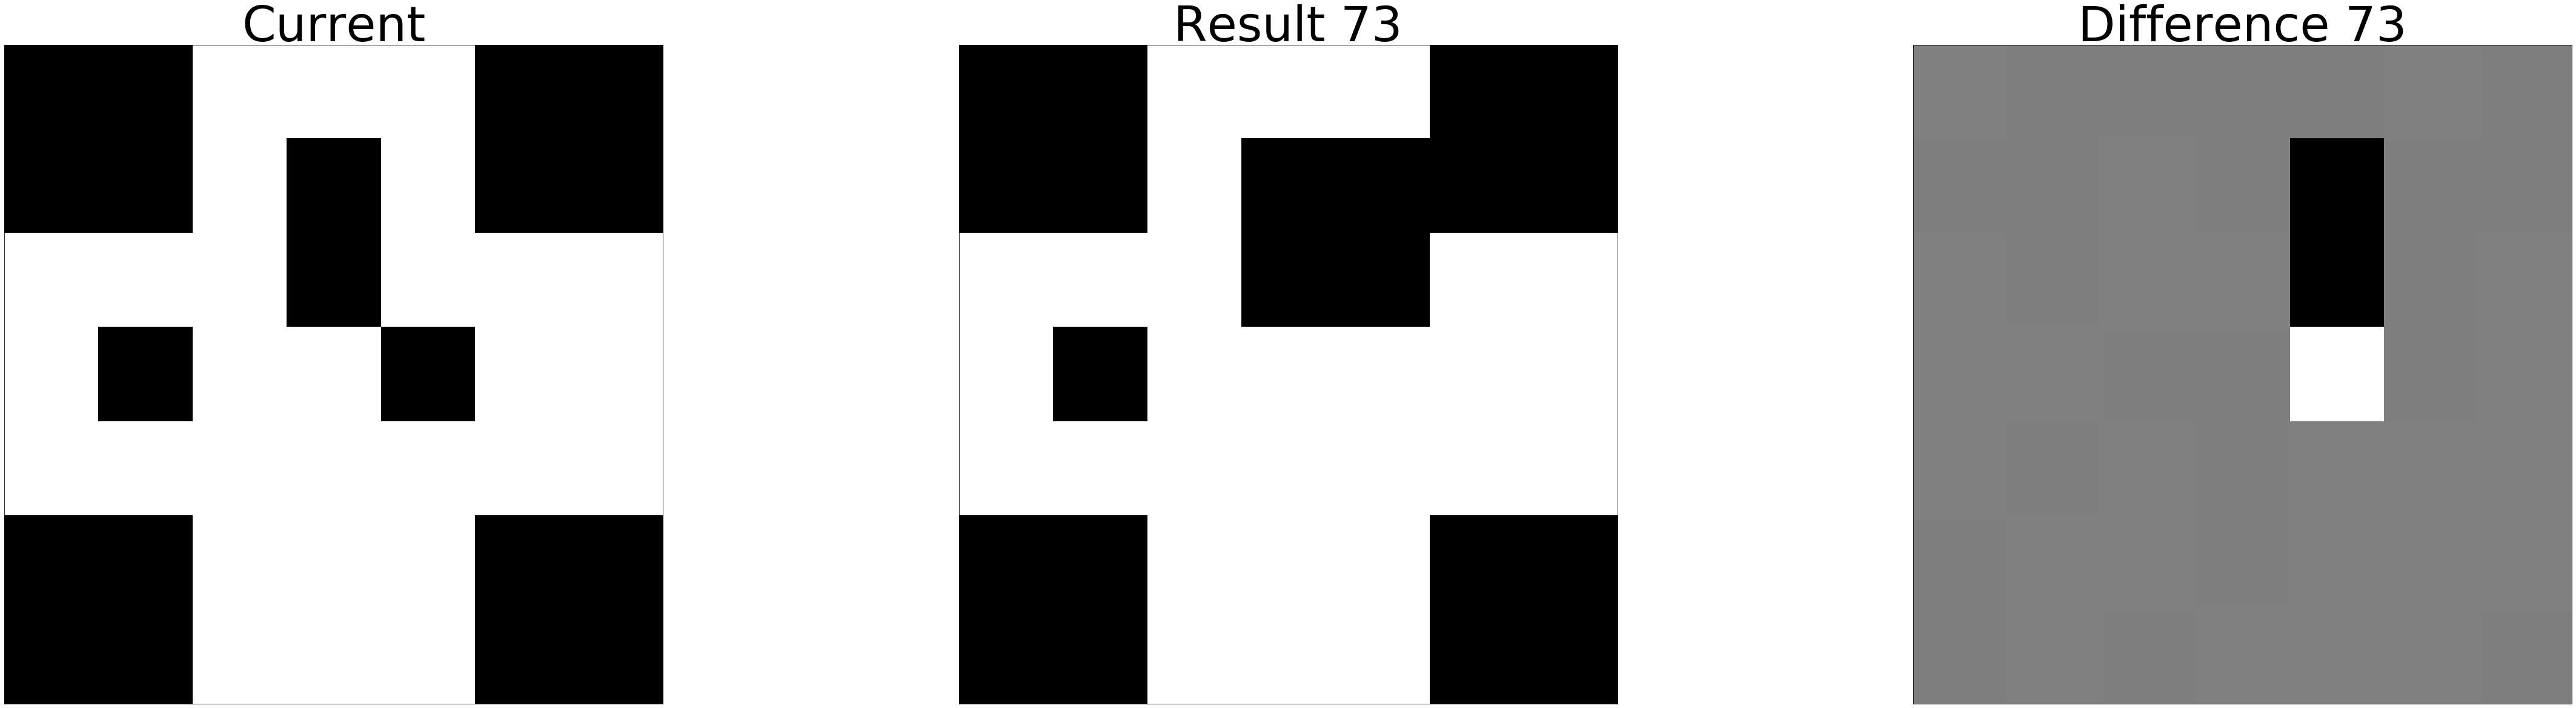

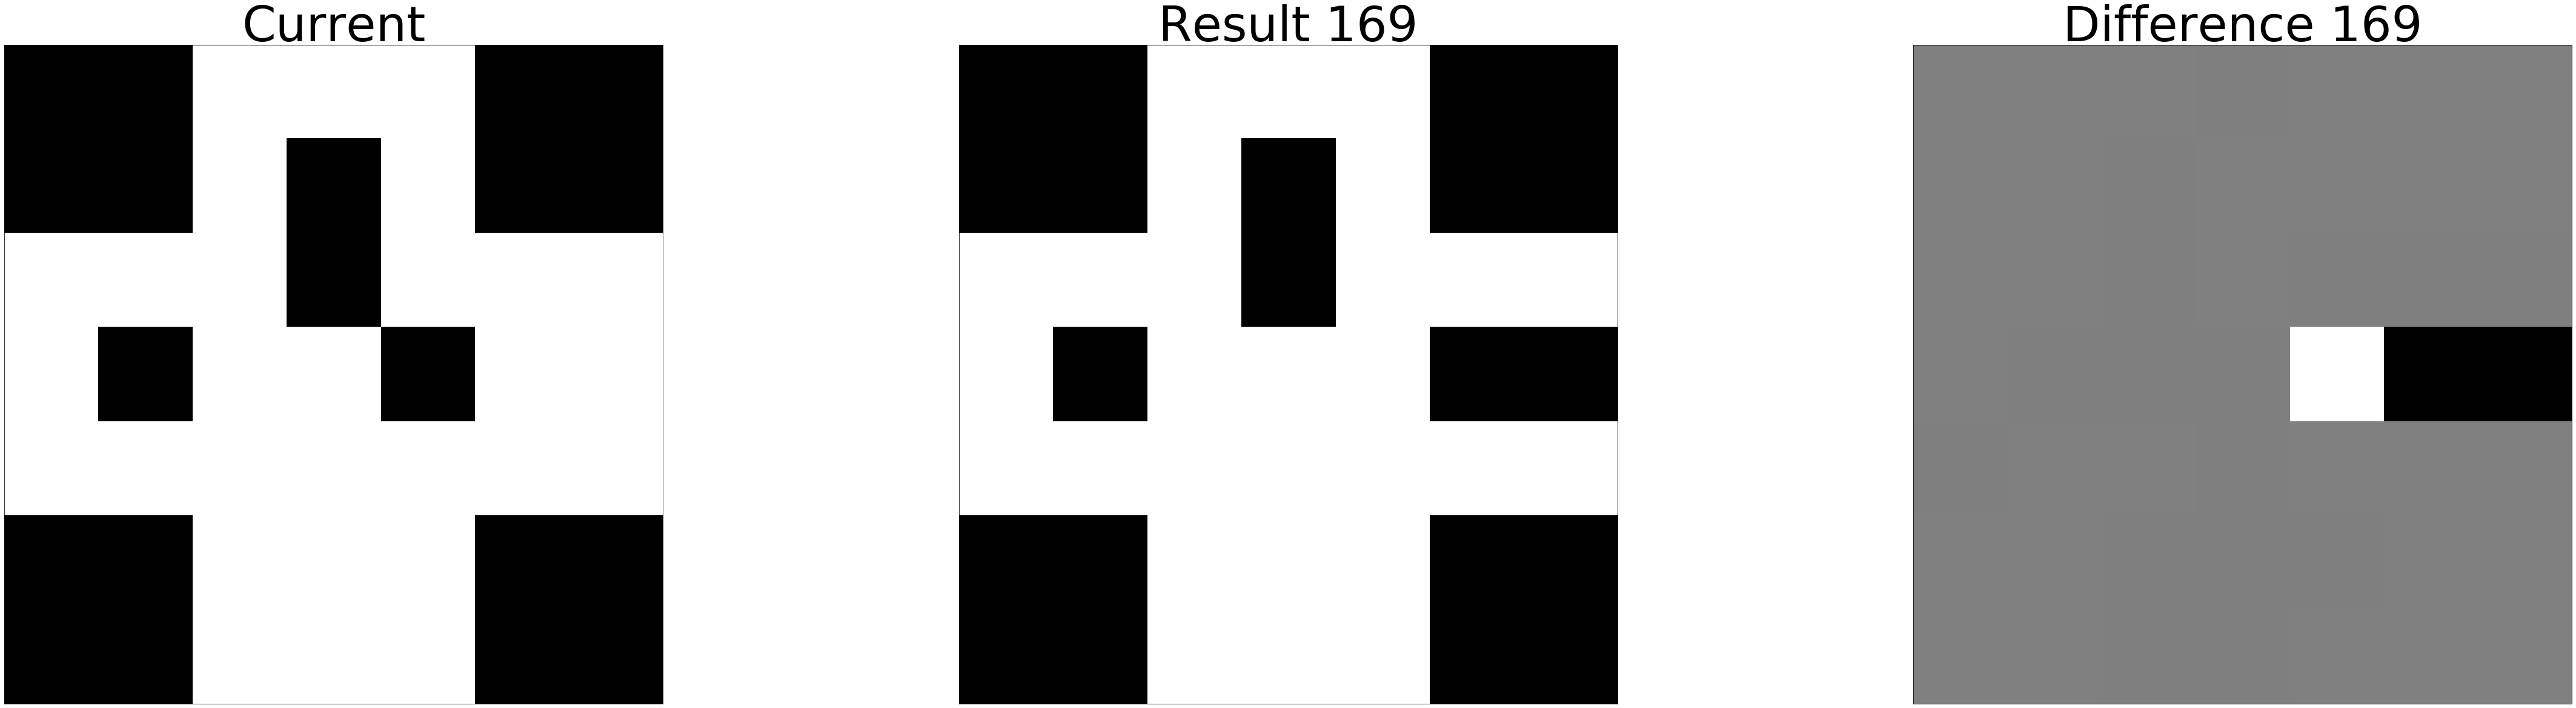

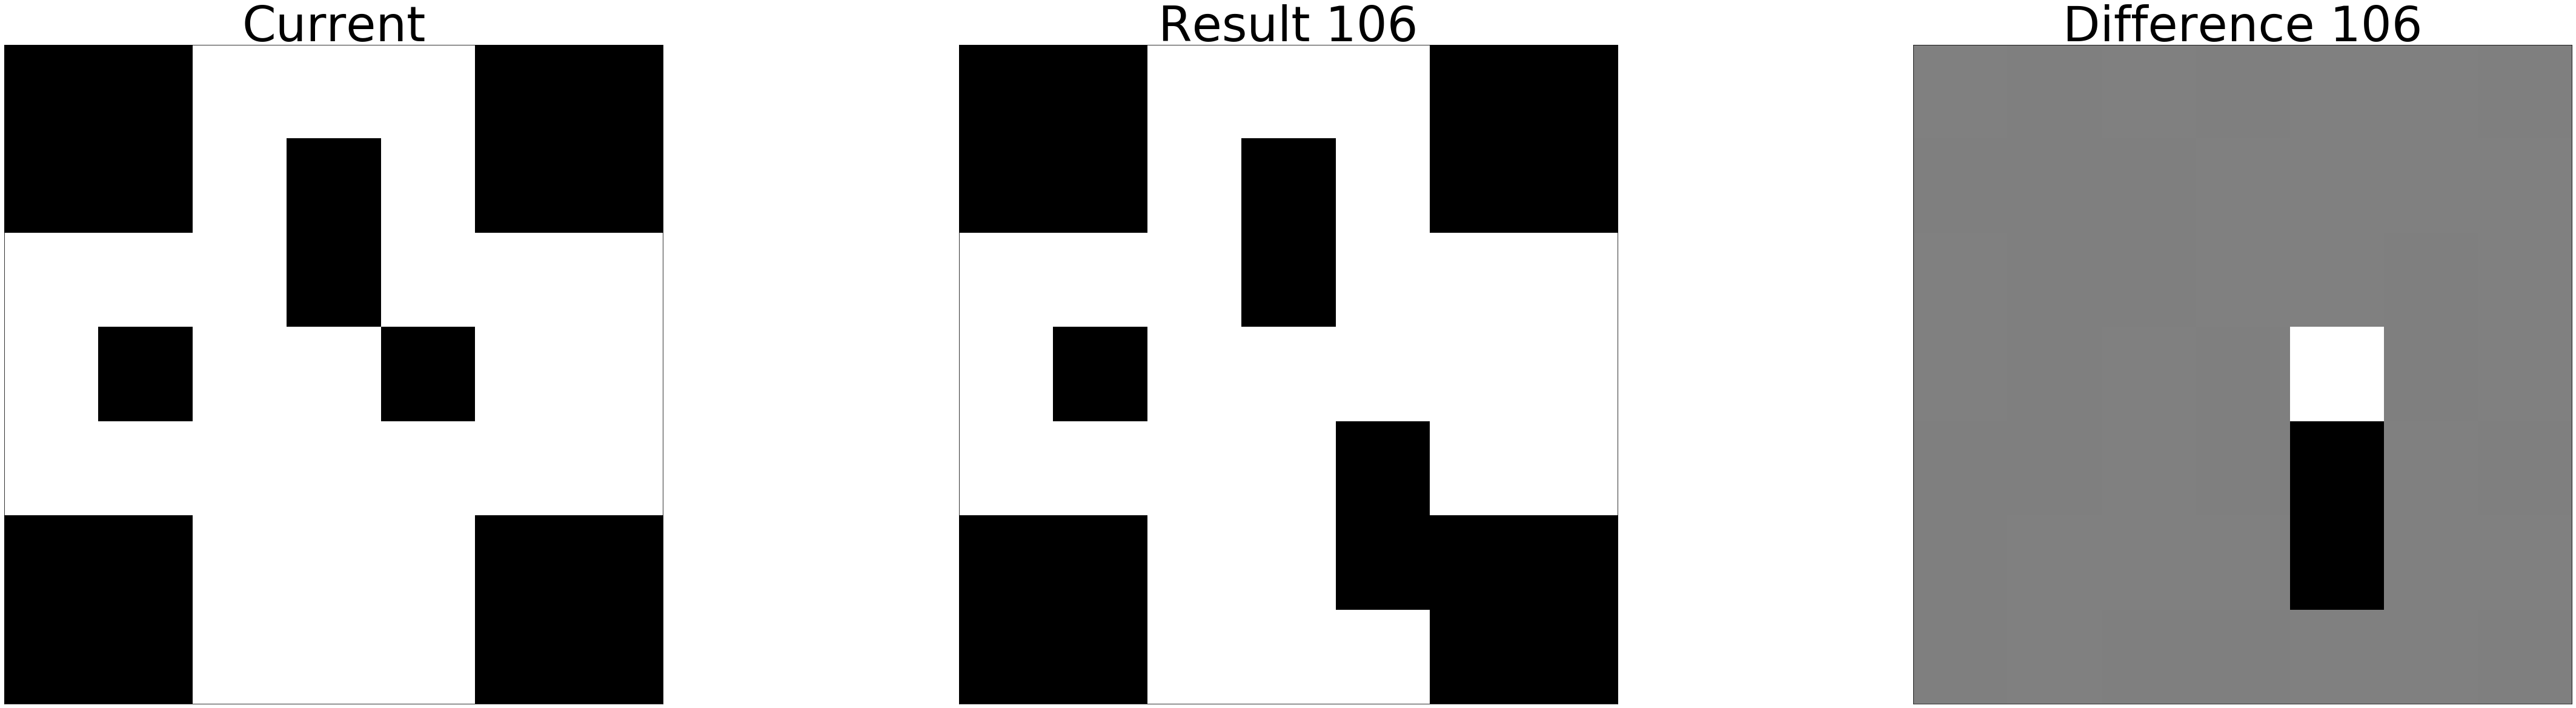

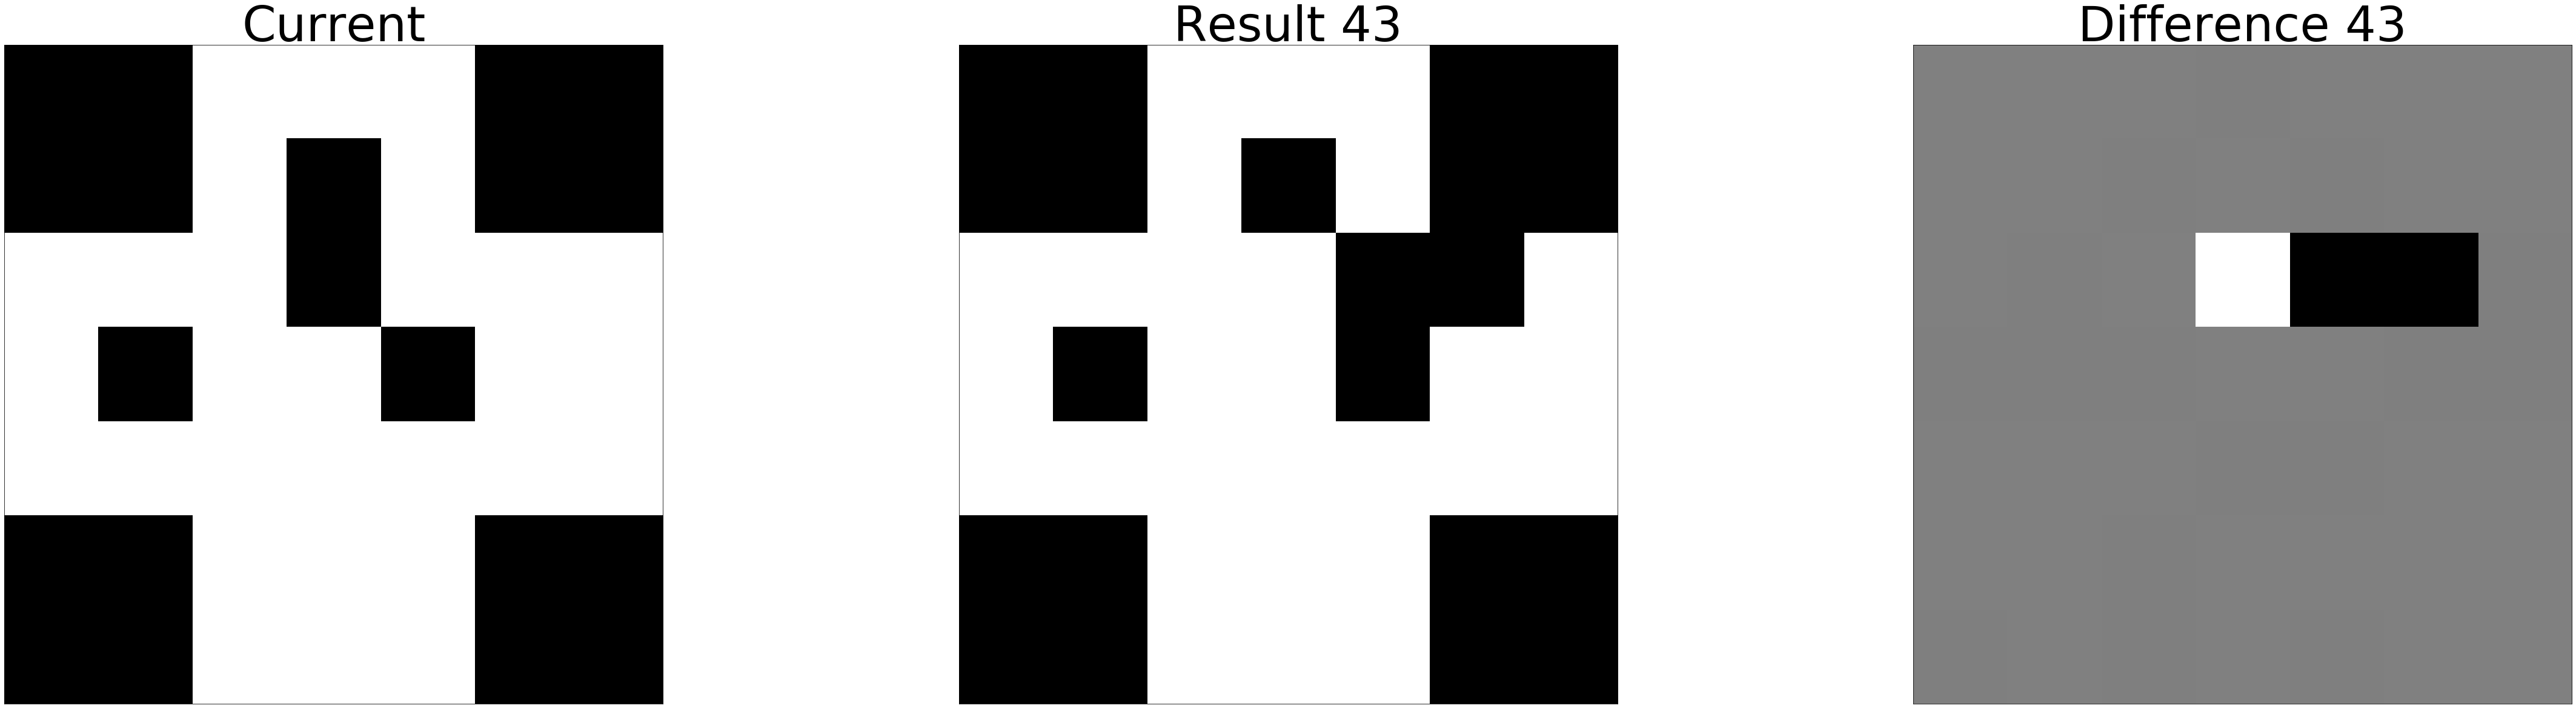

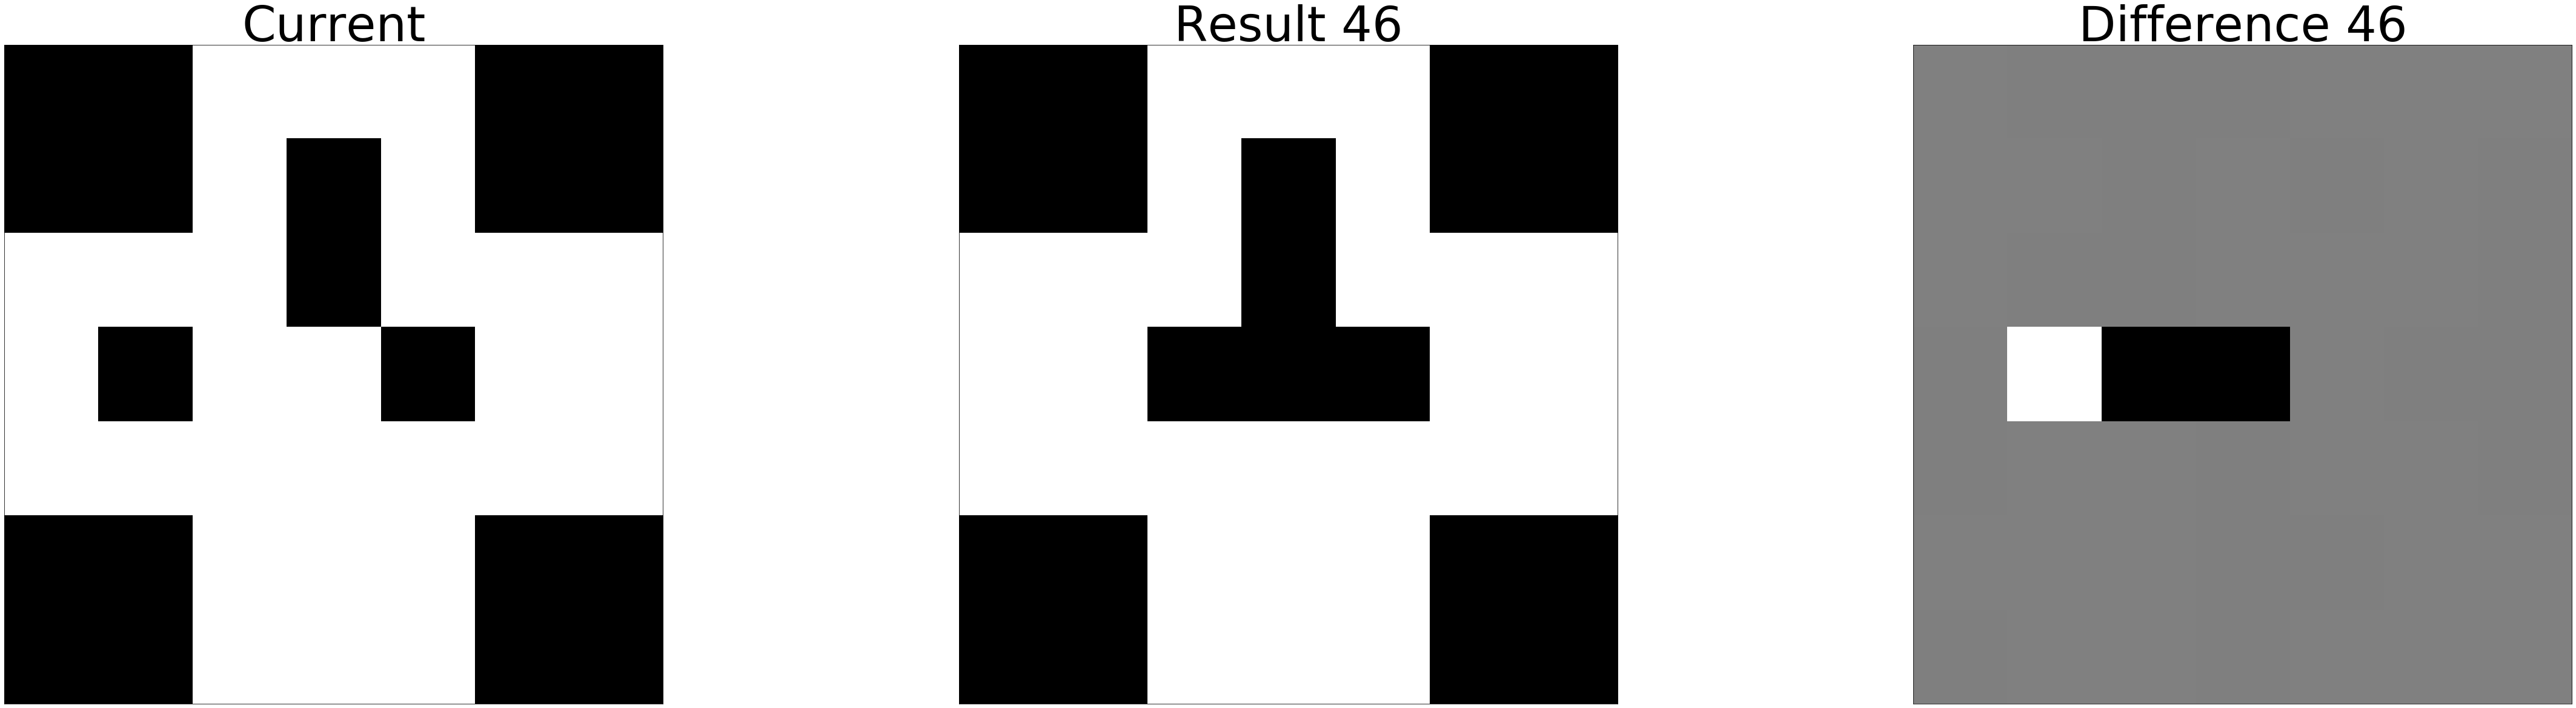

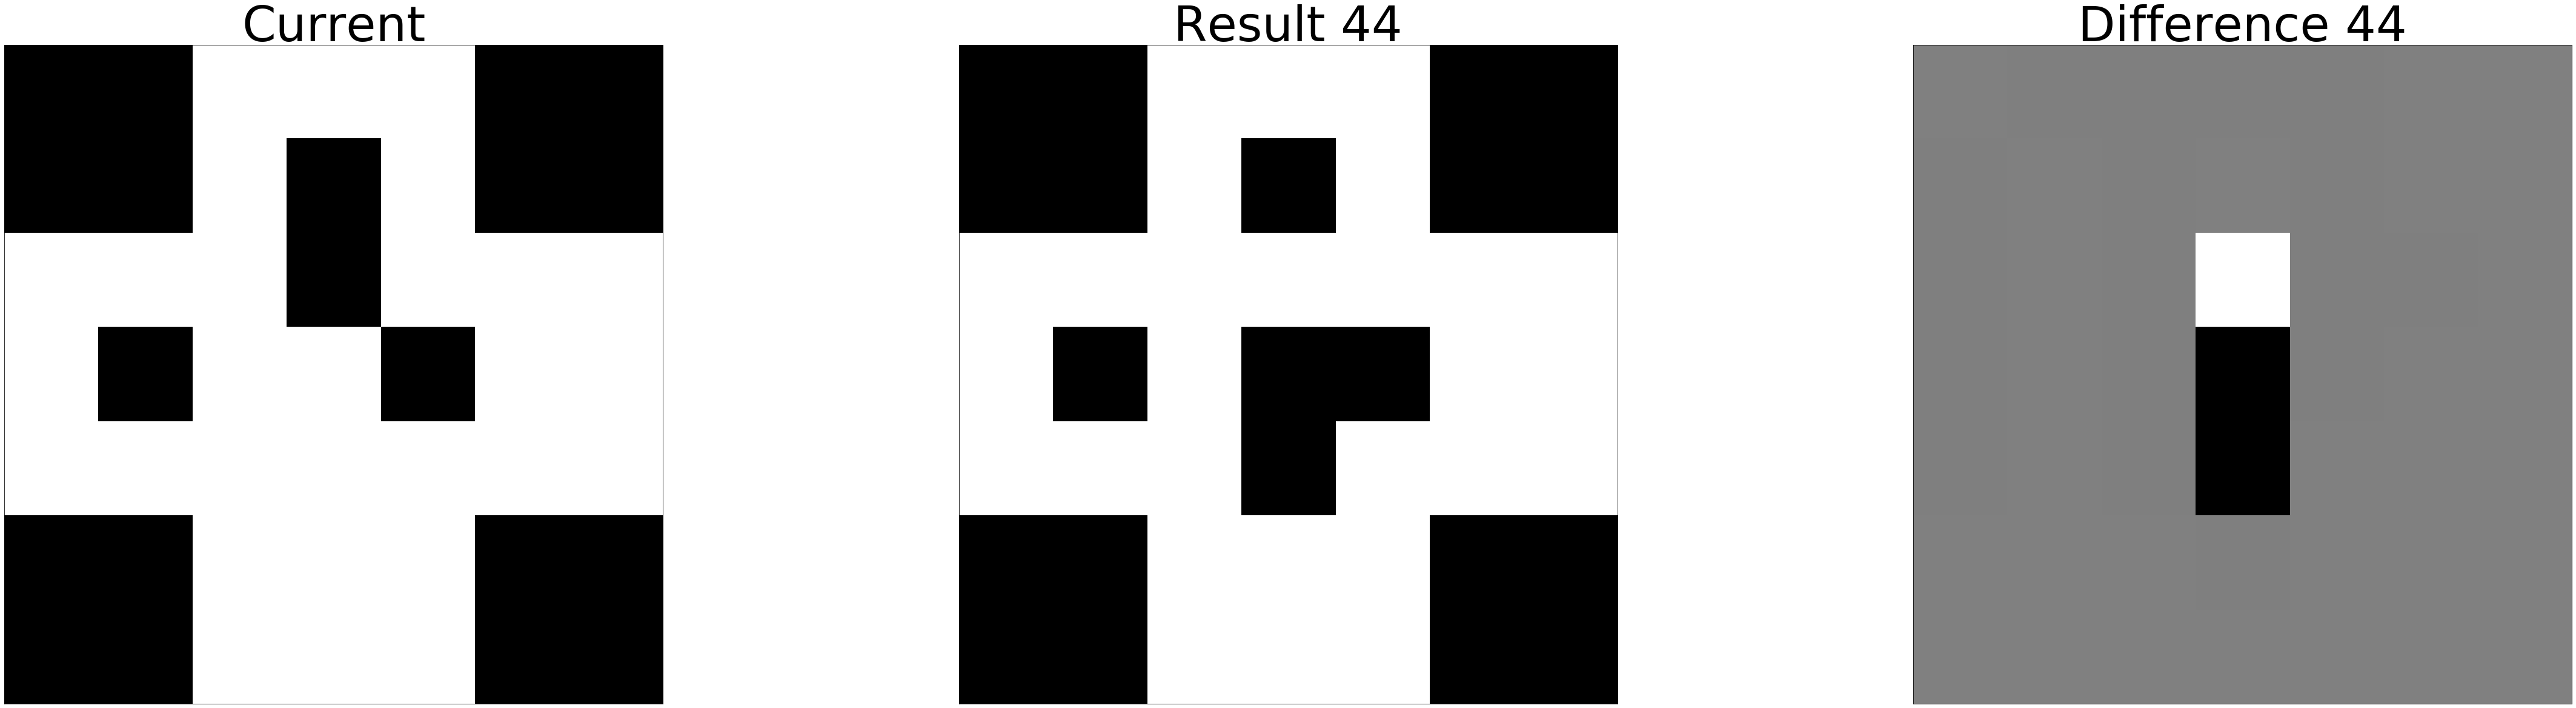

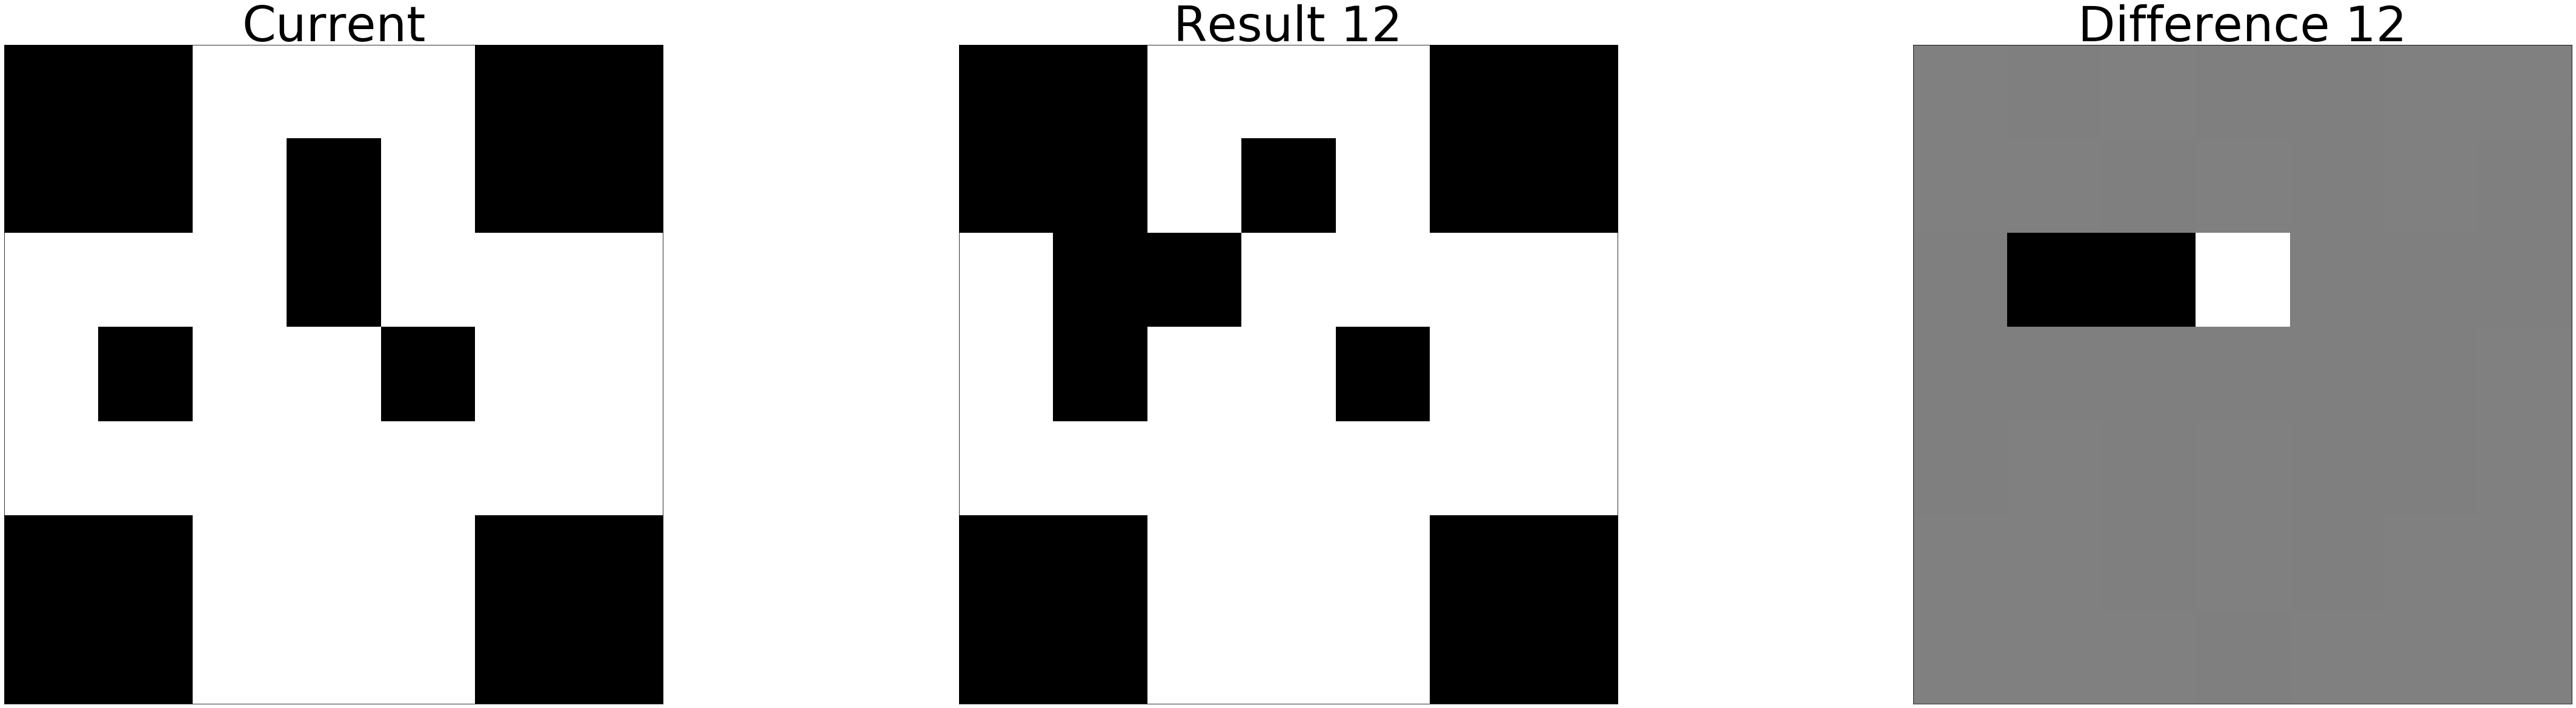

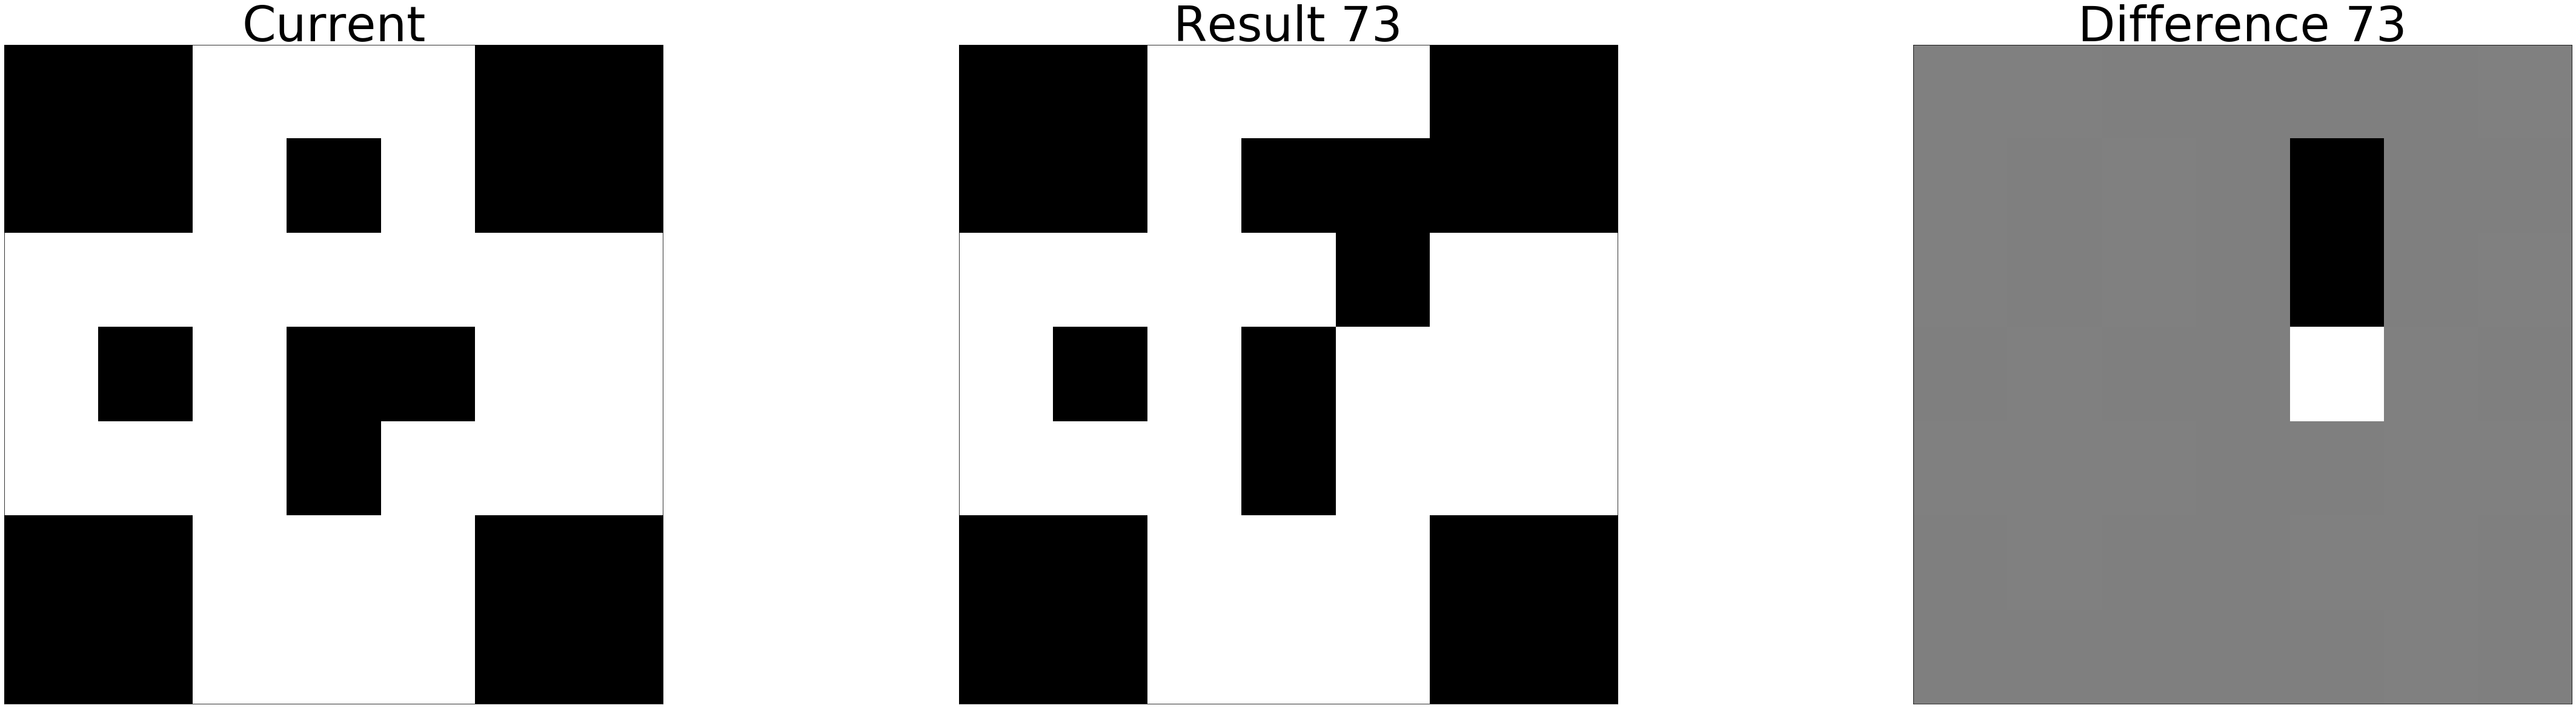

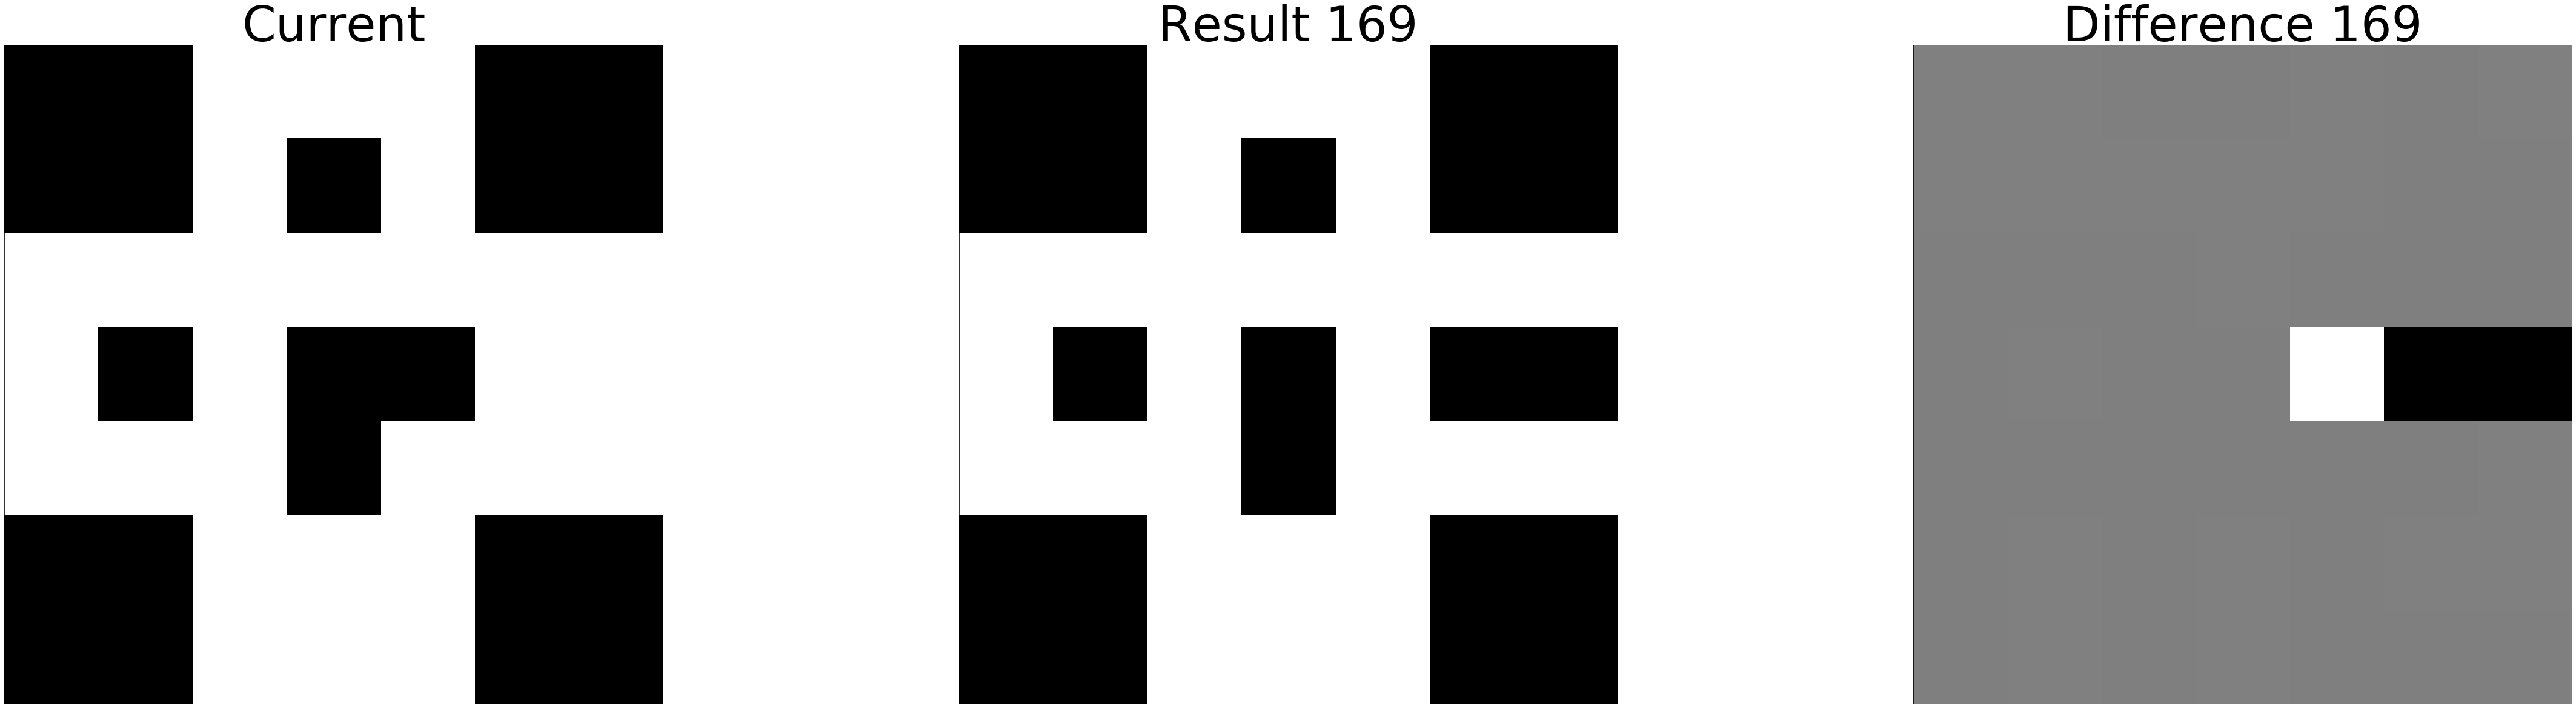

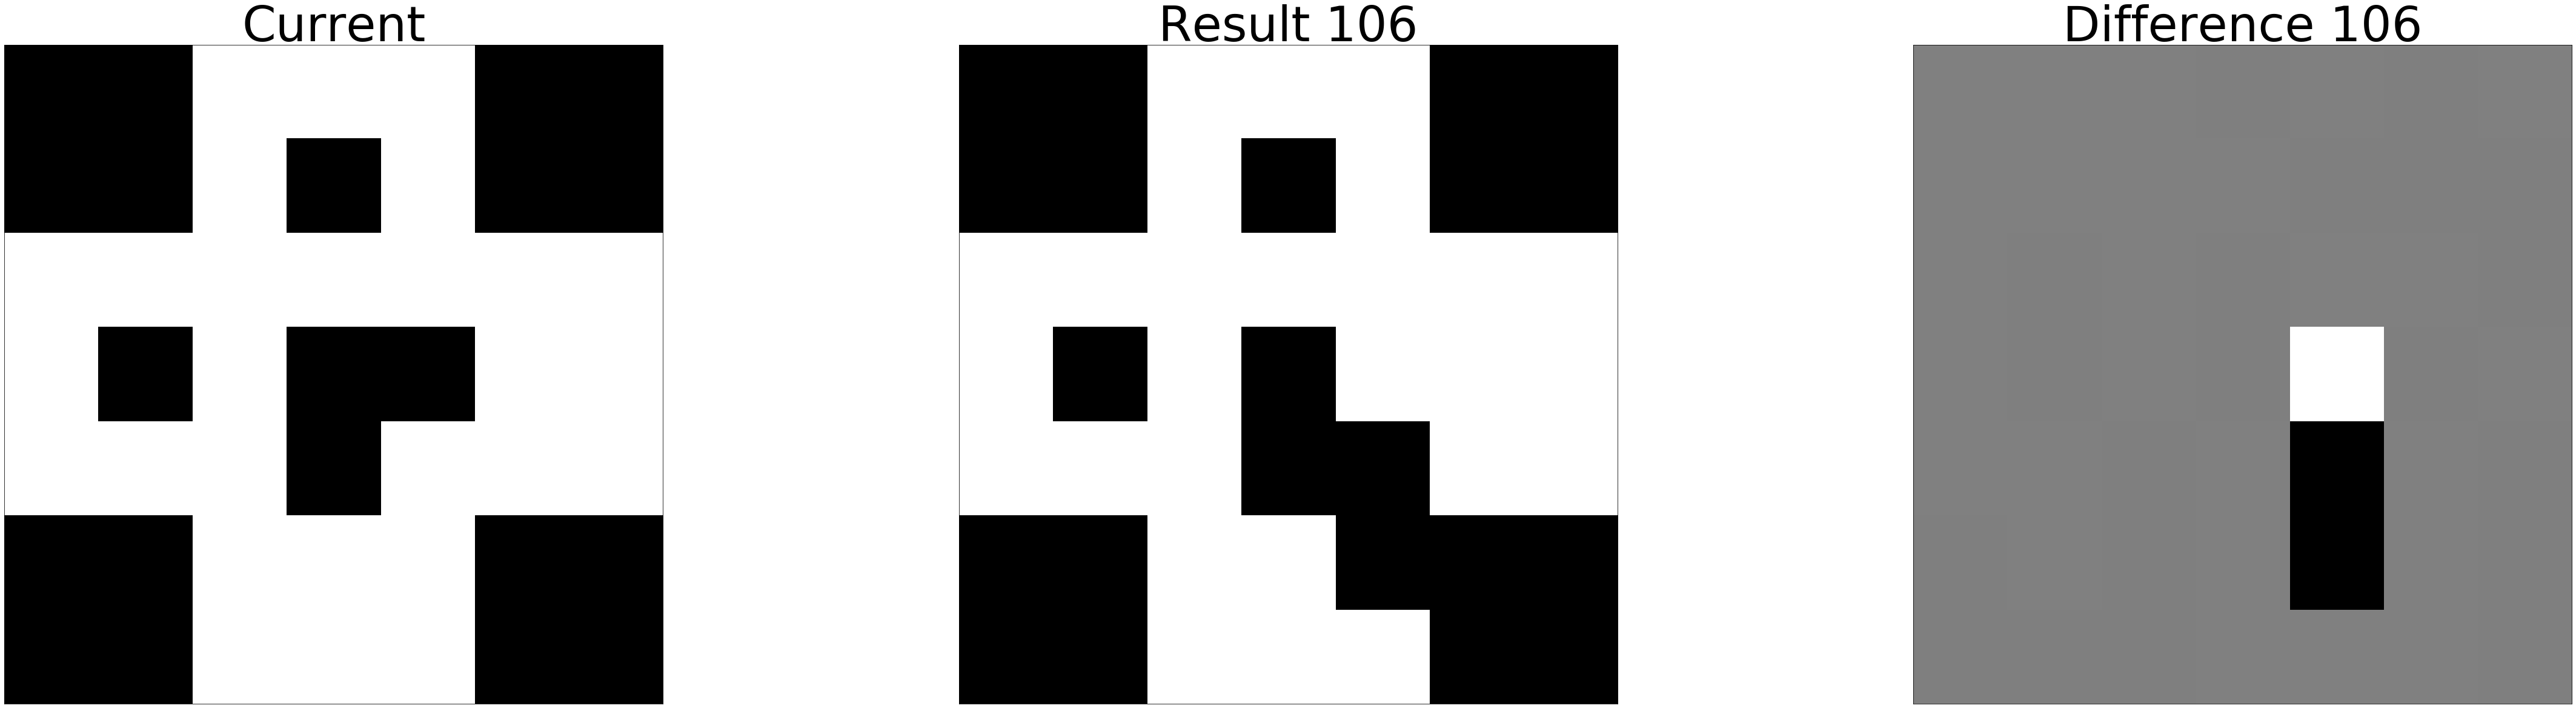

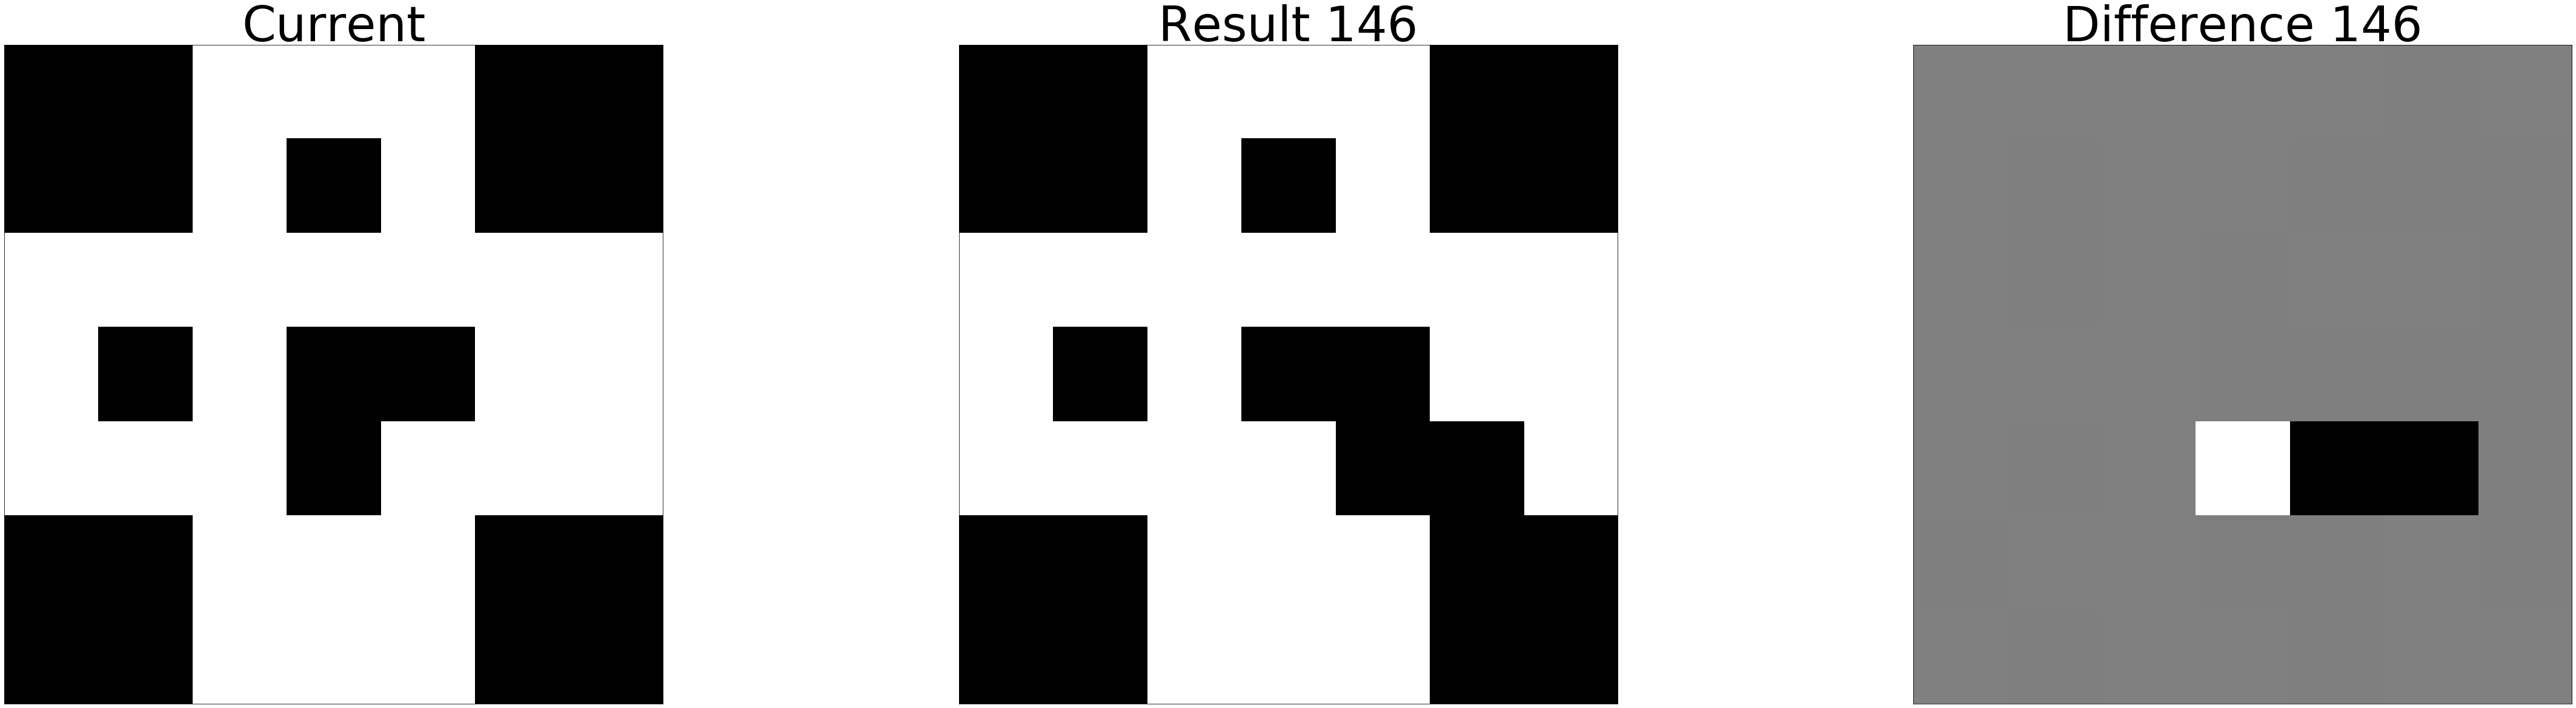

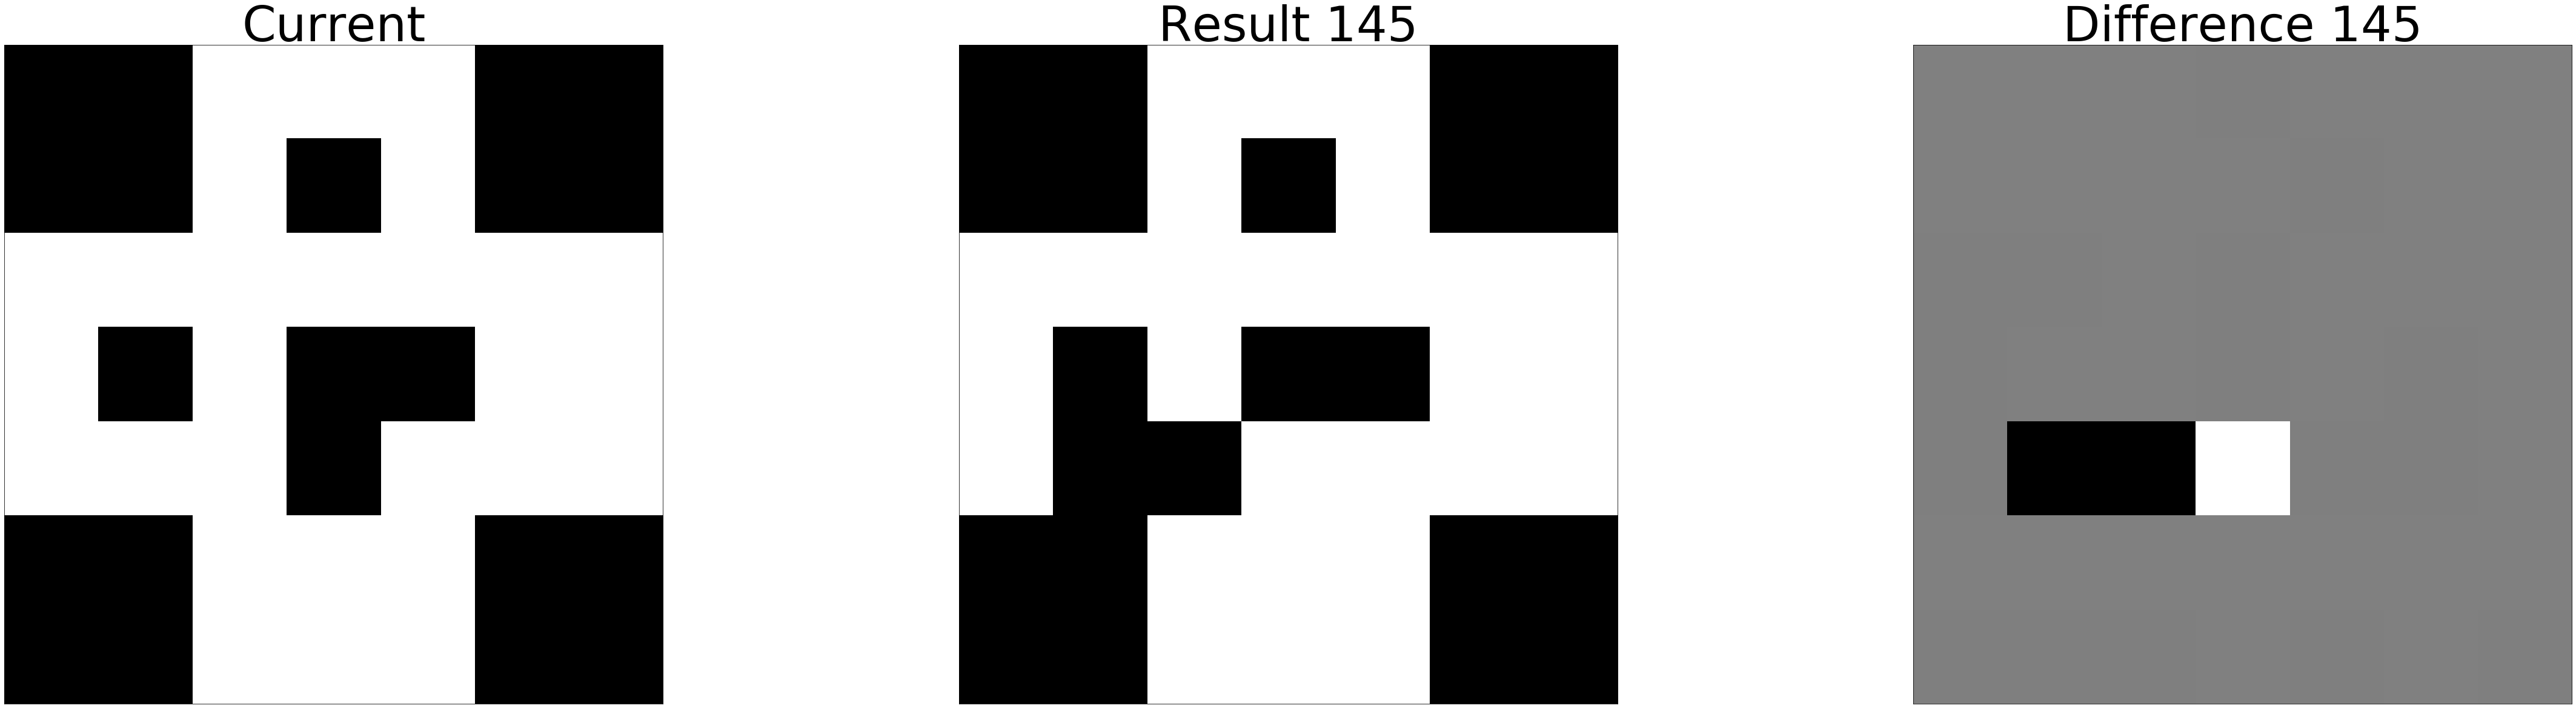

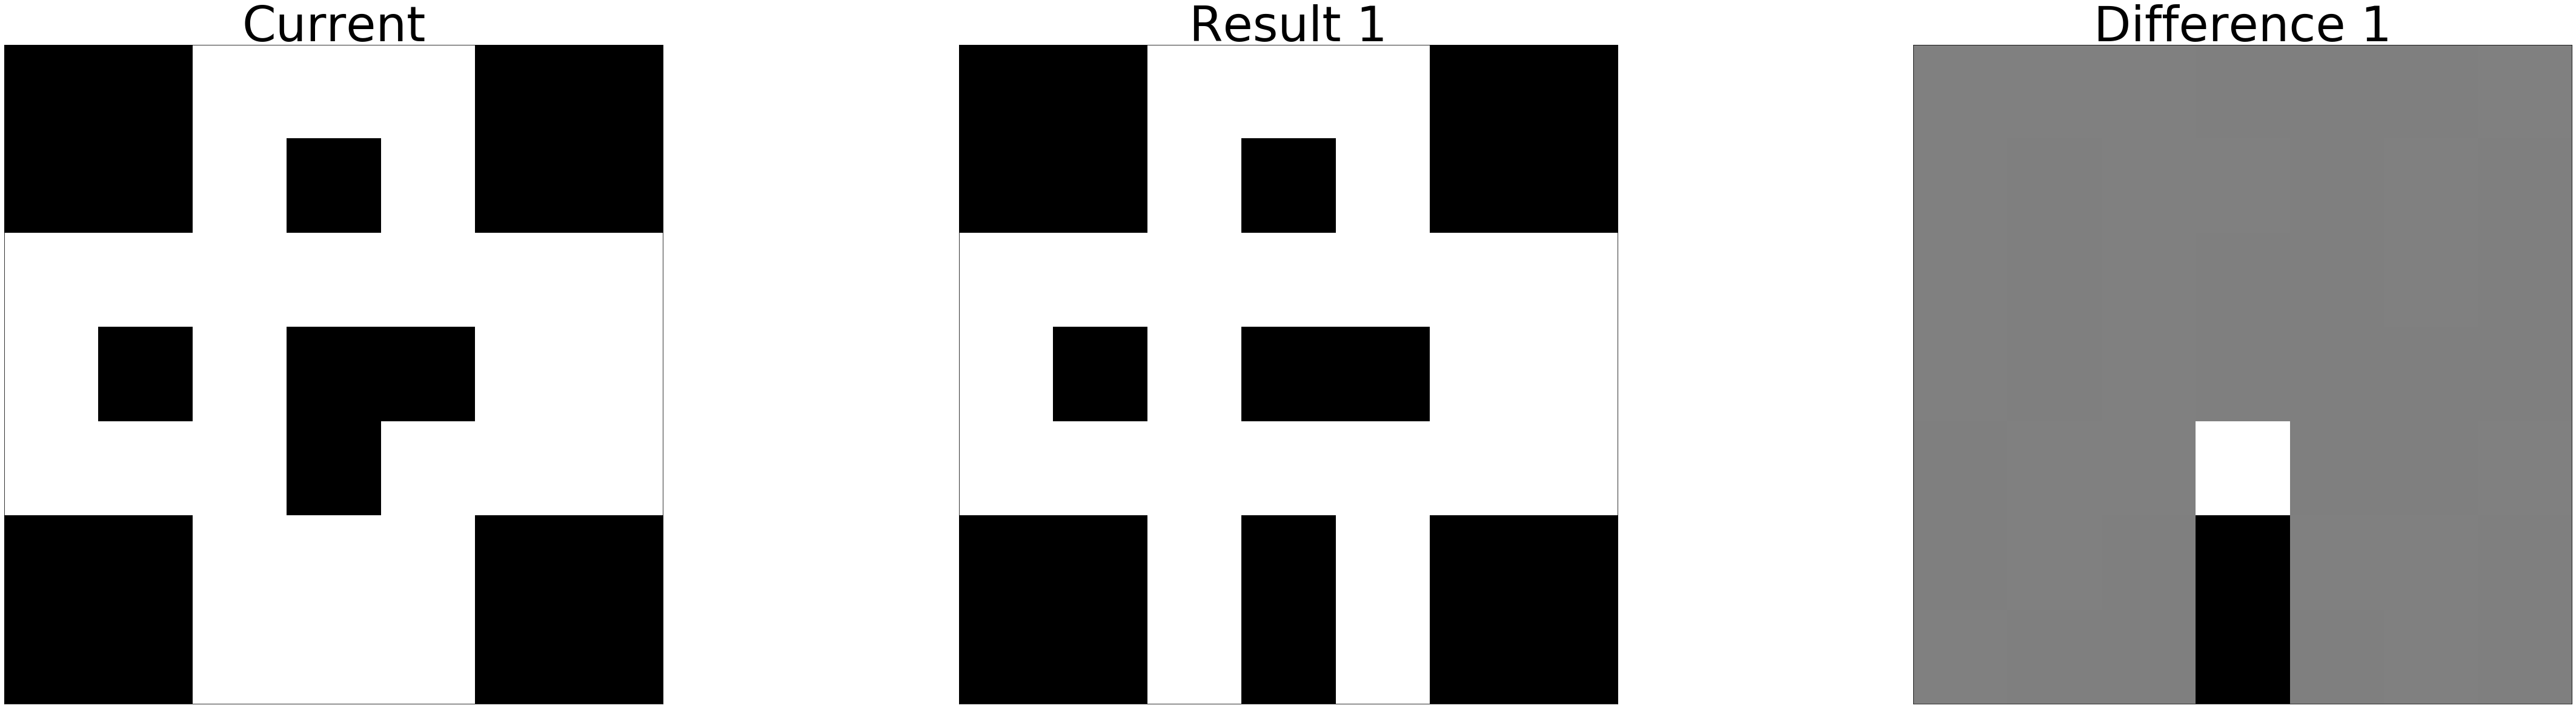

In [4]:
# Random Walk
currentState = PegSimulator().sampleSequence(1)
currentStateEncoded = sae_model.encode(currentState)

prunePU = 0.5
pruneAE = 0.5
randomSteps = 5
randomPath = [] # Define path, optionally
showAll = True
for i in range(randomSteps):
    print('-------------- STEP {} ---------------------'.format(i))

    # Calculate all possibly valid successors
    all_actions = allActionsBinary(ACTION_ENCODING)
    all_actions_number = np.arange(all_actions.shape[0])
    states = np.repeat(currentStateEncoded[:, :, 0], all_actions.shape[0], axis=0)
    results = aae_model.decode(states, all_actions)
    results = roundLatentBinary(results)

    # Only unique results
    results, indices = np.unique(results, axis=0, return_index=True)
    all_actions = all_actions[indices]
    all_actions_number = all_actions_number[indices]
    print('Unique Actions:', results.shape[0])

    # Prune with SD
    results_eval = sd_model.predict(results)[:, 0]
    results_eval = results_eval > (prunePU * sd_C)

    all_actions = all_actions[results_eval]
    all_actions_number = all_actions_number[results_eval]
    results = results[results_eval]
    print('Prune SD:', results.shape[0])

    # Prune with AD
    states = np.repeat(currentStateEncoded[:, :, 0], all_actions.shape[0], axis=0)
    results_eval = ad_model.predict(states, results)[:, 0]
    results_eval = results_eval > (prunePU * ad_C)

    all_actions = all_actions[results_eval]
    all_actions_number = all_actions_number[results_eval]
    results = results[results_eval]
    print('Prune AD:', results.shape[0])

    # Encode/Decode Test SAE
    results_decoded = sae_model.decode(buildLatentBinary(results))
    results_encoded = sae_model.encode(results_decoded)[:, :, 0]
    difference = np.sum(np.abs(results - results_encoded), axis=1)
    difference_eval = difference < pruneAE

    all_actions = all_actions[difference_eval]
    all_actions_number = all_actions_number[difference_eval]
    results = results[difference_eval]
    results_decoded = results_decoded[difference_eval]
    print('Enc/Dec SAE:', results.shape[0])

    # Encode/Decode Test AAE
    states = np.repeat(currentStateEncoded[:, :, 0], all_actions.shape[0], axis=0)
    actions = aae_model.encode(states, results)
    actions = roundLatentBinary(actions)
    results_aae = aae_model.decode(states, actions)
    difference = np.sum(np.abs(results - results_aae), axis=1)
    difference_eval = difference < pruneAE

    all_actions = all_actions[difference_eval]
    all_actions_number = all_actions_number[difference_eval]
    results = results[difference_eval]
    results_decoded = results_decoded[difference_eval]
    print('Enc/Dec AAE:', results.shape[0])


    if results.shape[0] > 0:
        # Randomly select successor or given path
        if i < len(randomPath):
            successor = np.where(all_actions_number == randomPath[i])[0][0]
        else:
            successor = np.random.randint(results.shape[0])

        # Show transitions
        for s in range(results.shape[0]):
            if s != successor and not showAll: #only show selected transition
                continue

            plt.figure(figsize=(80, 20))

            # current
            ax = plt.subplot(1, 3, 1)
            plt.imshow(currentState[0, :, :, 0], cmap=cm.gray, vmin=0, vmax=1)
            plt.title('Current', fontsize=80)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # result
            ax = plt.subplot(1, 3, 2)
            plt.imshow(results_decoded[s, :, :, 0], cmap=cm.gray, vmin=0, vmax=1)
            plt.title('Result {}'.format(all_actions_number[s]), fontsize=80)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # difference
            ax = plt.subplot(1, 3, 3)
            plt.imshow(results_decoded[s, :, :, 0] - currentState[0, :, :, 0], cmap=cm.gray, vmin=-1, vmax=1)
            plt.title('Difference {}'.format(all_actions_number[s]), fontsize=80)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # save figure
            plt.savefig('image/path_{}_{}.png'.format(i, s), dpi=100)

        # Update current state
        currentState = results_decoded[successor:successor+1]
        currentStateEncoded = results[successor:successor+1, :, np.newaxis]
    else:
        print('No further successor')
        break